# Lockdown  for Classification: Response to Radiation Therapy

## Import all necessary libraries

In [1]:
# Import libraries and modules
import numpy as np
import pandas as pd

import xgboost as xgb
from xgboost import plot_tree

from sklearn.metrics import r2_score, classification_report, confusion_matrix,           \
                            roc_curve, roc_auc_score, plot_confusion_matrix, f1_score,   \
                            balanced_accuracy_score, accuracy_score, mean_squared_error, \
                            log_loss
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier,    \
                                 Lasso, lasso_path
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper

import scipy
from scipy import stats

import os
import sys
import shutil
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import itertools

import time
import tqdm
import copy

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset

import PIL
import joblib
import json

# import mysgd

## Datasets and DataLoaders

In [2]:
# Load data
def load_data(fname):
    """
    input (str or path): name of the folder with the data.
    This function reads the data, transforms it to tensors, and makes it
    global.
    """
    global xtrain, xvalid, xtest, xtrain_valid, ytrain, yvalid, ytest, ytrain_valid
# 
    df = pd.read_csv(os.path.join(fname, 'xtrain.csv'), index_col=False, header=None)
    xtrain = torch.tensor(df.values).float()
    df = pd.read_csv(os.path.join(fname, 'xvalid.csv'), index_col=False, header=None)
    xvalid = torch.tensor(df.values).float()
    df = pd.read_csv(os.path.join(fname, 'xtest.csv'), index_col=False, header=None)
    xtest = torch.tensor(df.values).float()
    df = pd.read_csv(os.path.join(fname, 'xtrain_valid.csv'), index_col=False, header=None)
    xtrain_valid = torch.tensor(df.values).float()
# 
    df = pd.read_csv(os.path.join(fname, 'ytrain.csv'), index_col=False, header=None)
    ytrain = torch.tensor(df.values).long()
    df = pd.read_csv(os.path.join(fname, 'yvalid.csv'), index_col=False, header=None)
    yvalid = torch.tensor(df.values).long()
    df = pd.read_csv(os.path.join(fname, 'ytest.csv'), index_col=False, header=None)
    ytest = torch.tensor(df.values).long()
    df = pd.read_csv(os.path.join(fname, 'ytrain_valid.csv'), index_col=False, header=None)
    ytrain_valid = torch.tensor(df.values).long()

In [3]:
# Transform DataFrame to Tensor
def df_to_tensor():
    """
    This function transforms DataFrames to tensors and makes them global.
    """
    global xtrain, xvalid, xtest, ytrain, yvalid, ytest
# 
    xtrain = torch.tensor(xtrain.values).float()
    xvalid = torch.tensor(xvalid.values).float()
    xtest = torch.tensor(xtest.values).float()
# 
    ytrain = torch.tensor(ytrain.values).long()
    yvalid = torch.tensor(yvalid.values).long()
    ytest = torch.tensor(ytest.values).long()

* ### Read and Clean Data

In [3]:
# Read X and y
X = pd.read_csv('dataset_11Radiotherapy/GDS3017_gene_profile.csv', index_col=0)
dfy = pd.read_csv('dataset_11Radiotherapy/GDS3017_output.csv', index_col=0)

In [4]:
# Impute with mean
X.dropna(axis=1, how='all', inplace=True)
X.fillna(X.mean(), inplace=True)
cols_all = X.columns

# Set target
dfy.replace({'agent': {"radiotherapy": 1, "chemoradiotherapy": 0}}, inplace=True)
y = pd.DataFrame(dfy['agent'])

In [6]:
# Display data set info
n_features = X.shape[1]
print("- Number of features: {}\n".format(n_features))

print("- Dataset shape: {}\n".format(X.shape))

print("- Missing (X) values: {} points.".format(X.isna().sum().sum()))
print("- Missing (y) values: {} points.\n".format(y.isna().sum().sum()))

print("- Class probabilities:")
print("  label = 1: {}%".format(100*(y.iloc[:,0] == 1).sum()/len(y)))
print("  label = 0: {}%\n".format(100*(y.iloc[:,0] == 0).sum()/len(y)))

- Number of features: 54352

- Dataset shape: (156, 54352)

- Missing (X) values: 0 points.
- Missing (y) values: 0 points.

- Class probabilities:
  label = 1: 51.282051282051285%
  label = 0: 48.717948717948715%



* ### Split and Save

In [7]:
# # Random seeds for the splits
# seed1 = torch.randint(0, 1000, (500,))
# seed2 = torch.randint(1001, 2000, (500,))
seed1 = pd.read_csv('seed1.csv', header=None).iloc[:,0].tolist()
seed2 = pd.read_csv('seed2.csv', header=None).iloc[:,0].tolist()

In [8]:
# Split data (function)
def split_data(dfX, dfy, seed1=0, seed2=42):
    global xtrain, xvalid, xtest, xtrain_valid, ytrain, yvalid, ytest, ytrain_valid
    xtrain_valid, xtest, ytrain_valid, ytest = train_test_split(dfX, dfy, 
                                                      test_size=0.2, 
                                                      random_state=seed1)
    xtrain, xvalid, ytrain, yvalid = train_test_split(xtrain_valid, ytrain_valid, 
                                                      test_size=0.25, 
                                                      random_state=seed2)

In [10]:
# Set (xtrain, ytrain), (xvalid, yvalid), and (xtest, ytest)
data_folder = 'dataset_11Radiotherapy'
split_data(X, y)

# Save data on disk
xtrain.to_csv(os.path.join(data_folder, 'xtrain.csv'), index=False, header=False)
xvalid.to_csv(os.path.join(data_folder, 'xvalid.csv'), index=False, header=False)
xtest.to_csv(os.path.join(data_folder, 'xtest.csv'), index=False, header=False)
xtrain_valid.to_csv(os.path.join(data_folder, 'xtrain_valid.csv'), index=False, header=False)
X.to_csv(os.path.join(data_folder, 'X.csv'), index=False, header=False)

ytrain.to_csv(os.path.join(data_folder, 'ytrain.csv'), index=False, header=False)
yvalid.to_csv(os.path.join(data_folder, 'yvalid.csv'), index=False, header=False)
ytest.to_csv(os.path.join(data_folder, 'ytest.csv'), index=False, header=False)
ytrain_valid.to_csv(os.path.join(data_folder, 'ytrain_valid.csv'), index=False, header=False)
y.to_csv(os.path.join(data_folder, 'y.csv'), index=False, header=False)

# 
print("- xtrain size: {}".format(xtrain.shape))
print("- xvalid size: {}".format(xvalid.shape))
print("- xtest size: {}".format(xtest.shape))
print("- xtrain_valid size: {}\n".format(xtrain_valid.shape))

- xtrain size: (93, 54352)
- xvalid size: (31, 54352)
- xtest size: (32, 54352)
- xtrain_valid size: (124, 54352)



* ### Create Datasets and DataLoaders

In [11]:
# Create Dataset class
class MyDataset(Dataset):
    '''
    Input:
        xtensor (torch tensor): data points; dimension [# of points, # of features]
        ytensor (torch tensor): y values; dimension [# of points]
    Output:
        the usual...
    '''
    def __init__(self, xtensor, ytensor):
        self.x = xtensor
        self.y = ytensor
    
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx,:], self.y[idx], idx

In [12]:
# Instantiate DataLoaders
def make_DataLoaders(batch_size=100000, num_workers = 0):
    """
    This function instantiate and makes global DataLoaders for training, 
    validation, and testing datasets. 
    """
# .create datasets
    train_dataset = MyDataset(xtrain, ytrain)
    valid_dataset = MyDataset(xvalid, yvalid)
    test_dataset = MyDataset(xtest, ytest)
    
# .make dataloaders global variables
    global train_dataloader, valid_dataloader, test_dataloader
    train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                                   batch_size = batch_size,
                                                   shuffle = True, 
                                                   num_workers=num_workers)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, 
                                                   batch_size = batch_size,
                                                   shuffle = True, 
                                                   num_workers=num_workers)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                                   batch_size = batch_size,
                                                   shuffle = False, 
                                                   num_workers=num_workers)
    print('- train minibatches =', len(train_dataloader))
    print('- valid minibatches =', len(valid_dataloader))
    print('- test minibatches =', len(test_dataloader))

In [13]:
# Select type of processor to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cuda'):
    print("-Type of precessor to be used: 'gpu'")
    !nvidia-smi
else:
    print("-Type of precessor to be used: 'cpu'")
    
# Choose device
# torch.cuda.set_device(6)

-Type of precessor to be used: 'cpu'


## Optimizer and Loss Function

In [14]:
# Set up SGD optimizer with a constant learning rate
def setup_SGD(model, lr):
    """
    Args:
        model (nn.Module class): model previously instantiated
        lr (float): learning rate
    Returns:
        instantiated optimizer
    """
    return optim.SGD(model.parameters(), lr=lr, momentum=0,  weight_decay=0.0)

In [15]:
# Set up Adam optimizer with a constant learning rate
def setup_ADAM(model, lr):
    """
    Args:
        model (nn.Module class): model previously instantiated
        lr (float): learning rate
    Returns:
        instantiated optimizer
    """
    return optim.Adam(model.parameters(), lr=lr,  weight_decay=0.0)

In [16]:
# Type of Loss Function
loss_type = nn.CrossEntropyLoss(reduction='mean')

## Train model

In [17]:
# PyTorch sign function
def sgn(x):
    return torch.sign(x)

In [18]:
# Number of correct predictions in a multi-class classification problem
def accuracy_multiclass(output, target):
    """
    Args:
        output (torch tensor): 2D tensor of shape (batch_size, n_classes) resulting 
                               of running the model.
        target (torch tensor): 1D tensor with the corresponding class for each image.
    Returns:
        correct (int): number of correct predictions.
    """
    correct = 0
    prob_softmax = nn.Softmax(dim=1)
    _, predictions = torch.max(prob_softmax(output), dim=1)
    correct = (predictions == target).sum(dim=0)
    return correct

In [19]:
# Compute accuracy
def dataset_accuracy(data_loader, model, device):
    """
    Args:
        data_loader: torch DataLoader.
        model:       torch model previously trained.
        device: 'gpu' or 'cpu'.
    Returns:
        Accuracy for the given data set.
    """
# Initialize some local variables
    correct_total = 0
    n_points = 0
    
# Put model in evaluation mode
    model.eval()

# Loop over mini batches (no gradients need to be computed)
    with torch.no_grad():
        for i, (xx, yy, _) in enumerate(data_loader, start=1):
            batch_size = len(yy)
            xx = xx.to(device)
            yy = yy.to(device)
            yy_pred = model(xx)
        
# .compute accuracy (target size must be [batch_size])
            correct = accuracy_multiclass(yy_pred, yy.view(-1))
            correct_total += correct
        
# .number of points used after the ith mini-batch
            n_points += batch_size
#
    return correct_total.item()/n_points

In [20]:
# Train model (classification)
def train_model(lr, features, layer_sizes, lock_flag=False, epochs=3000, 
                early_stop=300, fname='model'):
    """
    """
# Set seed of random generators (for reproducibility purposes)
#     torch.manual_seed(42)

# Instantiate Model and Optimizer
    model = MyNet(features, layer_sizes)
    if lock_flag == True:
        model.load_state_dict(torch.load(model_forward_name))
    model = model.to(device)
    optimizer = setup_SGD(model, lr)

# LOCKDOWN SECTION 1:
    if lock_flag == True:
        n_iterations = epochs*len(train_dataloader)
        layers = get_lockdown_layers(model)
        t0 = []
        t0_initial = []
        sign_w0 = []
        l = 0
        for layer in layers:
            ww = layer.weight.detach()
            t0.append(abs(ww).sum())
            sign_w0.append(torch.sign(ww))
            t0_initial.append(t0[l])
            l += 1
    
# DataFrames to store train/valid loss function
    train_loss = pd.DataFrame(columns=['iteration', 'loss'])
    valid_loss = pd.DataFrame(columns=['iteration', 'loss'])

# Initialize some local variables...
    iteration = 0
    best_iter = 0
    best_loss = 1e30
    stop_flag = 0

# Loop Over Number of Epochs
    iterator = tqdm.notebook.tqdm(range(1, epochs + 1), desc='Epochs loop')
    for n_epoch in iterator:
# 
# .Loop Over Mini-batches
        for ibatch, (xx, yy, _) in enumerate(train_dataloader, start=1):
#
# ..Compute Validation Loss
            model_dict = copy.deepcopy(model.state_dict())
            epoch_loss = valid_epoch(valid_dataloader, model, loss_type, device)
            valid_loss = valid_loss.append({'iteration': iteration + 1, 
                                            'loss': epoch_loss}, 
                                            ignore_index=True)
# ..Train Mini-batch:
            model.train()
            xx = xx.to(device)
            yy = yy.to(device)
            yy_pred = model(xx)

# ..Compute Train Loss
            loss = loss_type(yy_pred, yy.view(-1))
            train_loss = train_loss.append({'iteration': iteration + 1,
                                            'loss': loss.item()}, 
                                           ignore_index=True)
# ..Backward Propagation
            optimizer.zero_grad()
            loss.backward()

# ..LOCKDOWN SECTION 2:
            if lock_flag == True:
                l = 0
                for layer in layers:
# ...weights and gradients (2D)
                    w2d = layer.weight.detach()
                    g2d = layer.weight.grad.detach()
                    w_shape = g2d.size()

# ...flattens weights and compute P(W)
                    w1d = torch.flatten(w2d)
                    Pw = abs(w1d).sum()

# ...find g=-grads, 'gamma', and sort gamma (in descending order)
                    p1d = 1.0
                    g1d = -torch.flatten(g2d)
                    gamma = abs(g1d)/(p1d + 1e-10)
                    _, indx1d = torch.sort(gamma, descending=True)

# ...Modify Gradients Accordingly:
                    grmin = torch.zeros(w_shape).fill_(1e-1).to(device)
                    layer.weight.grad = torch.sign(g2d)*torch.max(abs(g2d), grmin)
                    gr1d = torch.flatten(layer.weight.grad.detach())
                    pjsj = lr*abs(gr1d[indx1d])

# ...sign(g) != sign(w) elements
                    mask_ds = (sgn(g1d[indx1d]) != sgn(w1d[indx1d])) & (w1d[indx1d] != 0.0)
                    DS_sum = pjsj[mask_ds].sum()
                    pjsj[mask_ds] = 0.0
                    mask_dsc = ~mask_ds
                    indx1d_dsc = indx1d[mask_dsc]

# ...sum(pjsj), j={1,J-1}
                    left_side = torch.cumsum(pjsj, dim=0) - pjsj
                    pjsj_dsc = torch.zeros(len(g1d)).to(device)
                    pjsj_dsc[:] = pjsj[:]

# ...sum(pjsj) + Penalty, j={J+1,nJ}
                    mask_w0 = (w1d[indx1d] == 0.0)
                    pjsj_dsc[mask_w0] = 0.0
                    right_side = pjsj_dsc.sum() - torch.cumsum(pjsj_dsc, dim=0) + DS_sum - Pw + t0[l]

# ...delta_j and new steps
                    ds = right_side - left_side
                    mask_w0 = (~mask_w0).float()
                    pjsj_new = -mask_w0**(1-sgn(ds))*sgn(g1d[indx1d])*sgn(ds)*torch.min(pjsj, abs(ds))

# ...modify gradients
                    indx2d = np.unravel_index(indx1d_dsc.cpu(), shape=w_shape)
                    layer.weight.grad[indx2d] = pjsj_new[mask_dsc]/lr
                    l = l + 1

# ..Update Weights 
            optimizer.step()

# ..LOCKDOWN SECTION 3:
            if lock_flag == True:
# ...Set Weights That Change Signs to Zero
                l = 0
                for layer in layers:
                    ww = layer.weight.detach()
                    sign_w = sgn(ww)
                    mask0 = ((sign_w != sign_w0[l]) & (sign_w0[l] != 0.0))
                    with torch.no_grad():
                        layer.weight[mask0] = 0.0
                    sign_w0[l] = sign_w
                    
# ...Tighten Constraint
                    if iteration%step == 0:
                        t0[l] = (1.0 - iteration/n_iterations)*t0_initial[l]
                    l = l + 1
                    

# ..Early Stop
            batch_loss = valid_loss.iloc[iteration, 1]
            if batch_loss < best_loss:
                torch.save(model_dict, fname+"_best.pth")
                best_loss = batch_loss
                best_iter = iteration
            else:
                if iteration - best_iter >= early_stop:
                    stop_flag = 1
                    break
# 
            iteration += 1
# 
        if stop_flag == 1:
            break
# 
    if lock_flag == False:
        torch.save(model_dict, fname+"_last.pth")
    print("Summary:")
    print("-learning rate = {:.5f}".format(lr))
    if stop_flag == 1:
        print('-path 1 has early stopped:')
        print(' {:d} iterations with no improvement in train loss.'.format(early_stop))
    print("-Model saved after iteration {:d}.".format(best_iter + 1))
    print("-Train.  Loss={:.7f}".format(train_loss.iloc[best_iter, 1]))
    print("-Valid.  Loss={:.7f}".format(valid_loss.iloc[best_iter, 1]))
# 
    return train_loss, valid_loss

In [21]:
# Evaluate one epoch (classification)
def valid_epoch(data_loader, model, loss_type, device):
    """
    Args:
        data_loader: torch DataLoader.
        model:       torch model previously trained.
        device: 'gpu' or 'cpu'.
    Returns:
        Values of Loss Function after one epoch.
    """
# Initialize some local variables
    loss_fun = 0.
    n_points = 0
    
# Put model in evaluation mode
    model.eval()

# Loop over mini batches (no gradients need to be computed)
    with torch.no_grad():
        for i, (xx, yy, _) in enumerate(data_loader, start=1):
            xx = xx.to(device)
            yy = yy.to(device)
            yy_pred = model(xx)
        
# .compute loss function
            batch_size = len(yy)
            loss = loss_type(yy_pred, yy.view(-1))
            loss_fun += batch_size*loss.item()
        
# .number of points used after the ith mini-batch
            n_points += batch_size
#
    return loss_fun/n_points

## Results:

* ### Lasso

In [9]:
# Load data
load_data('dataset_11Radiotherapy')

# transform tensors to NumPy arrays
xtrain = xtrain.numpy()
xvalid = xvalid.numpy()
xtest = xtest.numpy()

ytrain = ytrain.numpy()
yvalid = yvalid.numpy()
ytest = ytest.numpy()

In [10]:
# Normalize data sets
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain = scaler.transform(xtrain)
xvalid = scaler.transform(xvalid)
xtest  = scaler.transform(xtest)

In [11]:
# Grid search space
grid_C = np.geomspace(1e-2, 1e3, num=1000)
df_grid_loss = pd.DataFrame(columns = ['C', 'valid_loss', 'valid_accu'], 
                            index=range(len(grid_C)))

params = {'penalty': 'l1', 
          'solver': 'liblinear',
          'max_iter': 10000,
          'random_state': 42,
          'warm_start': True}

In [12]:
# Perform grid search
data_out = 'data_lasso_11Radiotherapy'
iterator = tqdm.notebook.tqdm(range(1, len(grid_C) + 1), desc='C-grid loop')
for n in iterator:
    irow = n-1
    params['C'] = grid_C[irow]
    log_clf = LogisticRegression(**params).fit(xtrain, ytrain.ravel())
    
    ypred = log_clf.predict_proba(xvalid)
    val_loss = log_loss(yvalid, ypred)
    val_accu = log_clf.score(xvalid, yvalid.ravel())
    
    df_grid_loss.iloc[irow,:] = [params['C'], val_loss, val_accu]
    print("C={:.5f} | valid_logloss={:.5f},  valid_accu={:.5f}".format(params['C'], 
                                                                       val_loss, 
                                                                       val_accu))
    
df_grid_loss.to_csv(os.path.join(data_out, 'df_grid_loss.csv'), index=None)

C-grid loop:   0%|          | 0/1000 [00:00<?, ?it/s]

C=0.01000 | valid_logloss=0.69315,  valid_accu=0.48387
C=0.01012 | valid_logloss=0.69315,  valid_accu=0.48387
C=0.01023 | valid_logloss=0.69315,  valid_accu=0.48387
C=0.01035 | valid_logloss=0.69315,  valid_accu=0.48387
C=0.01047 | valid_logloss=0.69315,  valid_accu=0.48387
C=0.01059 | valid_logloss=0.69315,  valid_accu=0.48387
C=0.01072 | valid_logloss=0.69315,  valid_accu=0.48387
C=0.01084 | valid_logloss=0.69315,  valid_accu=0.48387
C=0.01097 | valid_logloss=0.69315,  valid_accu=0.48387
C=0.01109 | valid_logloss=0.69315,  valid_accu=0.48387
C=0.01122 | valid_logloss=0.69315,  valid_accu=0.48387
C=0.01135 | valid_logloss=0.69315,  valid_accu=0.48387
C=0.01148 | valid_logloss=0.69315,  valid_accu=0.48387
C=0.01162 | valid_logloss=0.69315,  valid_accu=0.48387
C=0.01175 | valid_logloss=0.69315,  valid_accu=0.48387
C=0.01189 | valid_logloss=0.69315,  valid_accu=0.48387
C=0.01202 | valid_logloss=0.69315,  valid_accu=0.48387
C=0.01216 | valid_logloss=0.69315,  valid_accu=0.48387
C=0.01231 

C=0.05569 | valid_logloss=0.62199,  valid_accu=0.74194
C=0.05633 | valid_logloss=0.62003,  valid_accu=0.74194
C=0.05698 | valid_logloss=0.61826,  valid_accu=0.74194
C=0.05764 | valid_logloss=0.61596,  valid_accu=0.74194
C=0.05831 | valid_logloss=0.61297,  valid_accu=0.74194
C=0.05899 | valid_logloss=0.60959,  valid_accu=0.77419
C=0.05967 | valid_logloss=0.60662,  valid_accu=0.77419
C=0.06036 | valid_logloss=0.60355,  valid_accu=0.77419
C=0.06106 | valid_logloss=0.60060,  valid_accu=0.77419
C=0.06177 | valid_logloss=0.59746,  valid_accu=0.77419
C=0.06249 | valid_logloss=0.59461,  valid_accu=0.80645
C=0.06321 | valid_logloss=0.59158,  valid_accu=0.80645
C=0.06394 | valid_logloss=0.58839,  valid_accu=0.80645
C=0.06469 | valid_logloss=0.58555,  valid_accu=0.80645
C=0.06544 | valid_logloss=0.58275,  valid_accu=0.80645
C=0.06619 | valid_logloss=0.58043,  valid_accu=0.80645
C=0.06696 | valid_logloss=0.57687,  valid_accu=0.80645
C=0.06774 | valid_logloss=0.57403,  valid_accu=0.80645
C=0.06852 

C=0.31009 | valid_logloss=0.43549,  valid_accu=0.93548
C=0.31369 | valid_logloss=0.44409,  valid_accu=0.93548
C=0.31732 | valid_logloss=0.43599,  valid_accu=0.93548
C=0.32100 | valid_logloss=0.46120,  valid_accu=0.93548
C=0.32472 | valid_logloss=0.46350,  valid_accu=0.93548
C=0.32849 | valid_logloss=0.44526,  valid_accu=0.93548
C=0.33229 | valid_logloss=0.45265,  valid_accu=0.93548
C=0.33614 | valid_logloss=0.44719,  valid_accu=0.93548
C=0.34004 | valid_logloss=0.46096,  valid_accu=0.93548
C=0.34398 | valid_logloss=0.44691,  valid_accu=0.93548
C=0.34797 | valid_logloss=0.44282,  valid_accu=0.93548
C=0.35200 | valid_logloss=0.45083,  valid_accu=0.93548
C=0.35608 | valid_logloss=0.45484,  valid_accu=0.93548
C=0.36021 | valid_logloss=0.47579,  valid_accu=0.93548
C=0.36439 | valid_logloss=0.47467,  valid_accu=0.93548
C=0.36861 | valid_logloss=0.42590,  valid_accu=0.93548
C=0.37288 | valid_logloss=0.43884,  valid_accu=0.93548
C=0.37720 | valid_logloss=0.46285,  valid_accu=0.93548
C=0.38158 

C=1.72678 | valid_logloss=0.55302,  valid_accu=0.93548
C=1.74680 | valid_logloss=0.53647,  valid_accu=0.93548
C=1.76704 | valid_logloss=0.56185,  valid_accu=0.93548
C=1.78753 | valid_logloss=0.54312,  valid_accu=0.93548
C=1.80824 | valid_logloss=0.50285,  valid_accu=0.93548
C=1.82920 | valid_logloss=0.48820,  valid_accu=0.93548
C=1.85041 | valid_logloss=0.51559,  valid_accu=0.93548
C=1.87186 | valid_logloss=0.59650,  valid_accu=0.93548
C=1.89355 | valid_logloss=0.54371,  valid_accu=0.93548
C=1.91550 | valid_logloss=0.51818,  valid_accu=0.93548
C=1.93770 | valid_logloss=0.55265,  valid_accu=0.93548
C=1.96016 | valid_logloss=0.52377,  valid_accu=0.93548
C=1.98288 | valid_logloss=0.47131,  valid_accu=0.93548
C=2.00587 | valid_logloss=0.49163,  valid_accu=0.93548
C=2.02912 | valid_logloss=0.58714,  valid_accu=0.93548
C=2.05264 | valid_logloss=0.55416,  valid_accu=0.93548
C=2.07643 | valid_logloss=0.49022,  valid_accu=0.93548
C=2.10050 | valid_logloss=0.45108,  valid_accu=0.93548
C=2.12485 

C=9.61575 | valid_logloss=0.53990,  valid_accu=0.93548
C=9.72720 | valid_logloss=0.56056,  valid_accu=0.93548
C=9.83995 | valid_logloss=0.61005,  valid_accu=0.93548
C=9.95401 | valid_logloss=0.58663,  valid_accu=0.93548
C=10.06939 | valid_logloss=0.59982,  valid_accu=0.93548
C=10.18610 | valid_logloss=0.60183,  valid_accu=0.93548
C=10.30417 | valid_logloss=0.62003,  valid_accu=0.93548
C=10.42361 | valid_logloss=0.61329,  valid_accu=0.93548
C=10.54443 | valid_logloss=0.62487,  valid_accu=0.93548
C=10.66665 | valid_logloss=0.59312,  valid_accu=0.93548
C=10.79029 | valid_logloss=0.58610,  valid_accu=0.93548
C=10.91536 | valid_logloss=0.55546,  valid_accu=0.93548
C=11.04188 | valid_logloss=0.64048,  valid_accu=0.93548
C=11.16987 | valid_logloss=0.71498,  valid_accu=0.93548
C=11.29934 | valid_logloss=0.62274,  valid_accu=0.93548
C=11.43031 | valid_logloss=0.53436,  valid_accu=0.93548
C=11.56280 | valid_logloss=0.63475,  valid_accu=0.93548
C=11.69683 | valid_logloss=0.65386,  valid_accu=0.93

C=52.32614 | valid_logloss=0.77435,  valid_accu=0.93548
C=52.93266 | valid_logloss=0.77425,  valid_accu=0.93548
C=53.54621 | valid_logloss=0.71647,  valid_accu=0.93548
C=54.16687 | valid_logloss=0.80552,  valid_accu=0.93548
C=54.79472 | valid_logloss=0.78419,  valid_accu=0.93548
C=55.42986 | valid_logloss=0.74026,  valid_accu=0.93548
C=56.07235 | valid_logloss=0.79849,  valid_accu=0.93548
C=56.72229 | valid_logloss=0.74718,  valid_accu=0.93548
C=57.37976 | valid_logloss=0.74236,  valid_accu=0.93548
C=58.04486 | valid_logloss=0.72507,  valid_accu=0.93548
C=58.71766 | valid_logloss=0.73761,  valid_accu=0.93548
C=59.39827 | valid_logloss=0.74346,  valid_accu=0.93548
C=60.08676 | valid_logloss=0.75415,  valid_accu=0.93548
C=60.78323 | valid_logloss=0.78067,  valid_accu=0.93548
C=61.48778 | valid_logloss=0.76063,  valid_accu=0.93548
C=62.20049 | valid_logloss=0.72240,  valid_accu=0.93548
C=62.92146 | valid_logloss=0.74592,  valid_accu=0.93548
C=63.65079 | valid_logloss=0.72317,  valid_accu=

C=278.25594 | valid_logloss=0.78240,  valid_accu=0.93548
C=281.48124 | valid_logloss=0.92709,  valid_accu=0.93548
C=284.74392 | valid_logloss=0.88197,  valid_accu=0.93548
C=288.04442 | valid_logloss=0.79121,  valid_accu=0.93548
C=291.38317 | valid_logloss=0.88754,  valid_accu=0.93548
C=294.76063 | valid_logloss=0.81773,  valid_accu=0.93548
C=298.17723 | valid_logloss=0.98050,  valid_accu=0.93548
C=301.63343 | valid_logloss=0.90451,  valid_accu=0.93548
C=305.12970 | valid_logloss=0.86165,  valid_accu=0.93548
C=308.66649 | valid_logloss=0.99697,  valid_accu=0.93548
C=312.24428 | valid_logloss=0.90427,  valid_accu=0.93548
C=315.86354 | valid_logloss=0.91453,  valid_accu=0.93548
C=319.52475 | valid_logloss=0.82456,  valid_accu=0.93548
C=323.22840 | valid_logloss=0.93638,  valid_accu=0.93548
C=326.97497 | valid_logloss=0.92778,  valid_accu=0.93548
C=330.76498 | valid_logloss=0.80059,  valid_accu=0.93548
C=334.59891 | valid_logloss=0.87828,  valid_accu=0.93548
C=338.47729 | valid_logloss=0.9

In [13]:
# Display grid search results
data_out = 'data_lasso_11Radiotherapy'
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_loss.csv'))

idx = df_grid_loss.valid_loss.idxmin()
best_C   = df_grid_loss.iloc[idx, 0]
best_loss  = df_grid_loss.iloc[idx, 1]
print("Best parameters ({}):".format(idx))
print("- Best C = {:.5f}".format(best_C))
print("- Best valid loss = {:.5f}".format(best_loss))

Best parameters (403):
- Best C = 1.03996
- Best valid loss = 0.41432


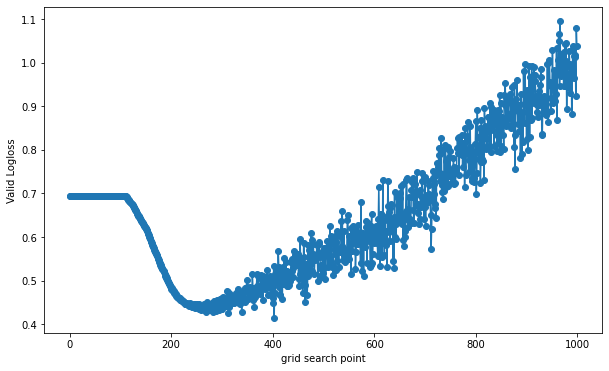

In [14]:
# Plot Loss vs point in grid search
data_out = 'data_lasso_11Radiotherapy'
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_loss.csv'))
fig, axes = plt.subplots(figsize=(10,6))
axes.scatter(df_grid_loss.index, df_grid_loss['valid_loss'])
axes.plot(df_grid_loss.index, df_grid_loss['valid_loss'])
axes.set_xlabel("grid search point")
axes.set_ylabel("Valid Logloss")
plt.show()

In [15]:
# Train with best hyperparameters
params['C'] = best_C
log_clf = LogisticRegression(**params).fit(xtrain, ytrain.ravel())

In [16]:
# Save model and model's best params
data_out = 'data_lasso_11Radiotherapy'
joblib.dump(log_clf, os.path.join(data_out, 'lasso_model_val.pkl'))
print("model saved at: '{}'".format(os.path.join(data_out, 'lasso_model_val.pkl')))

best_params = {}
best_params['C'] = best_C
with open(os.path.join(data_out, 'lasso_best_params.json'), 'w') as f:
    json.dump(best_params, f)
print("best params saved at: '{}'".format(os.path.join(data_out, 'lasso_best_params.json')))

model saved at: 'data_lasso_11Radiotherapy/lasso_model_val.pkl'
best params saved at: 'data_lasso_11Radiotherapy/lasso_best_params.json'


In [17]:
# Find MSE, R2, Accuracy, etc...
data_out = 'data_lasso_11Radiotherapy'
model = joblib.load(os.path.join(data_out, 'lasso_model_val.pkl'))

df_results = pd.DataFrame(index=['train', 'valid', 'test'], 
                           columns=['accuracy', 'roc_auc'])

ypred = model.predict(xtrain)
df_results.loc['train', 'accuracy'] = accuracy_score(ytrain, ypred)
df_results.loc['train', 'roc_auc']  = roc_auc_score(ytrain, ypred)

ypred = model.predict(xvalid)
df_results.loc['valid', 'accuracy'] = accuracy_score(yvalid, ypred)
df_results.loc['valid', 'roc_auc']  = roc_auc_score(yvalid, ypred)

ypred = model.predict(xtest)
df_results.loc['test', 'accuracy'] = accuracy_score(ytest, ypred)
df_results.loc['test', 'roc_auc']  = roc_auc_score(ytest, ypred)

# Save data
df_results.to_csv(os.path.join(data_out, 'results_target_val.csv'), index=True)
print("model results saved at: '{}'".format(os.path.join(data_out, 'results_target_val.csv')))
df_results.head()

model results saved at: 'data_lasso_11Radiotherapy/results_target_val.csv'


,accuracy,roc_auc
train,1,1
valid,0.935484,0.9375
test,0.9375,0.9375


In [19]:
# Find Accuracy +/- STD
data_in  = 'data_lasso_11Radiotherapy'
data_out = 'data_lasso_11Radiotherapy/partitions'
df_results = pd.DataFrame(columns=['train_acc', 'valid_acc', 'test_acc', 'train_roc', 'valid_roc', 'test_roc'])

model = joblib.load(os.path.join(data_in, 'lasso_model_val.pkl'))

partitions = 100
iterator = tqdm.notebook.tqdm(range(1, partitions + 1), desc='Partitions loop')
for n in iterator:
    split_data(X, y, seed1=seed1[n], seed2=seed2[n])
    
# .normalize data sets
    scaler = StandardScaler()
    scaler.fit(xtrain)
    xtrain = scaler.transform(xtrain)
    xvalid = scaler.transform(xvalid)
    xtest  = scaler.transform(xtest)
    
# .train model
    ytrain = ytrain.values.ravel()
    yvalid = yvalid.values.ravel()
    ytest  = ytest.values.ravel()
    model.fit(xtrain, ytrain)
    
# .compute/save accuracy
    ypred = model.predict(xtrain)
    df_results.loc[n, 'train_acc'] = accuracy_score(ytrain, ypred)
    df_results.loc[n, 'train_roc']  = roc_auc_score(ytrain, ypred)

    ypred = model.predict(xvalid)
    df_results.loc[n, 'valid_acc'] = accuracy_score(yvalid, ypred)
    df_results.loc[n, 'valid_roc']  = roc_auc_score(yvalid, ypred)

    ypred = model.predict(xtest)
    df_results.loc[n, 'test_acc'] = accuracy_score(ytest, ypred)
    df_results.loc[n, 'test_roc']  = roc_auc_score(ytest, ypred)

    joblib.dump(model, os.path.join(data_out, 'lasso_model_val_'+str(n)+'.pkl'))
    df_results.to_csv(os.path.join(data_out, 'accuracy_lasso_val.csv'), index=True)

Partitions loop:   0%|          | 0/100 [00:00<?, ?it/s]

In [21]:
# Display results
data_out = 'data_lasso_11Radiotherapy/partitions'
accuracy_lasso = pd.read_csv(os.path.join(data_out, 'accuracy_lasso_val.csv'))
print("Train accuracy = {:.3f} +/- {:.3f}".format(accuracy_lasso['train_acc'].mean(), 
                                                  accuracy_lasso['train_acc'].std()))
print("Valid accuracy = {:.3f} +/- {:.3f}".format(accuracy_lasso['valid_acc'].mean(), 
                                                  accuracy_lasso['valid_acc'].std()))
print("Test accuracy = {:.3f} +/- {:.3f}".format(accuracy_lasso['test_acc'].mean(), 
                                                 accuracy_lasso['test_acc'].std()))

Train accuracy = 1.000 +/- 0.000
Valid accuracy = 0.938 +/- 0.052
Test accuracy = 0.932 +/- 0.070


* ### Gradient Boosting

In [193]:
# Load data
load_data('dataset_11Radiotherapy')

# transform tensors to NumPy arrays
xtrain = xtrain.numpy()
xvalid = xvalid.numpy()
xtest = xtest.numpy()

ytrain = ytrain.numpy()
yvalid = yvalid.numpy()
ytest = ytest.numpy()

In [194]:
# Normalize data sets
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain = scaler.transform(xtrain)
xvalid = scaler.transform(xvalid)
xtest  = scaler.transform(xtest)

In [195]:
# Build DMatrices
dtrain = xgb.DMatrix(data=xtrain, label=ytrain, nthread=10, feature_names=cols_all)
dvalid = xgb.DMatrix(data=xvalid, label=yvalid, nthread=10, feature_names=cols_all)
dtest  = xgb.DMatrix(data=xtest,  label=ytest,  nthread=10, feature_names=cols_all)

valid_list = [(dtrain, 'train'), (dvalid, 'valid')]

In [196]:
# Grid search space
grid_eta   = np.geomspace(0.01, 0.99, num=100)
grid_depth = [1, 2, 3, 4, 5]
grid_param = [(eta, max_depth) for eta in grid_eta
                               for max_depth in grid_depth]

param = [('eta', 0.01), 
         ('max_depth', 2), 
         ('objective', 'binary:logistic'), 
         ('nthread', 10),
         ('eval_metric', 'logloss')
]

In [197]:
# Perform grid search
df_grid_loss = pd.DataFrame(columns = ['eta', 'max_depth', 'valid_loss'], 
                            index = range(len(grid_param)))
i = 0
for eta, max_depth in grid_param:
    param[0] = ('eta', eta)
    param[1] = ('max_depth', max_depth)
    
    xgb_clf = xgb.train(param, dtrain, 
                        num_boost_round = 5000, 
                        evals = valid_list, 
                        early_stopping_rounds = 20, 
                        verbose_eval = False)
    
    print("eta={}, max_depth={} | valid_logloss={:.5f} (iters={})".format(eta, 
                                                                          max_depth, 
                                                                          xgb_clf.best_score, 
                                                                          xgb_clf.best_iteration))
    df_grid_loss.iloc[i,:] = [eta, max_depth, xgb_clf.best_score]
    i += 1
    
# Save grid search results
    data_out = 'data_xgb_11Radiotherapy'
    df_grid_loss.to_csv(os.path.join(data_out, 'df_grid_loss.csv'), index=None)

eta=0.01, max_depth=1 | valid_logloss=0.29871 (iters=919)
eta=0.01, max_depth=2 | valid_logloss=0.20671 (iters=539)
eta=0.01, max_depth=3 | valid_logloss=0.24940 (iters=545)
eta=0.01, max_depth=4 | valid_logloss=0.24954 (iters=528)
eta=0.01, max_depth=5 | valid_logloss=0.24954 (iters=528)
eta=0.010475094057619858, max_depth=1 | valid_logloss=0.29836 (iters=839)
eta=0.010475094057619858, max_depth=2 | valid_logloss=0.21246 (iters=518)
eta=0.010475094057619858, max_depth=3 | valid_logloss=0.24616 (iters=505)
eta=0.010475094057619858, max_depth=4 | valid_logloss=0.24868 (iters=549)
eta=0.010475094057619858, max_depth=5 | valid_logloss=0.24868 (iters=549)
eta=0.010972759551598283, max_depth=1 | valid_logloss=0.29863 (iters=805)
eta=0.010972759551598283, max_depth=2 | valid_logloss=0.21305 (iters=491)
eta=0.010972759551598283, max_depth=3 | valid_logloss=0.24249 (iters=481)
eta=0.010972759551598283, max_depth=4 | valid_logloss=0.24564 (iters=474)
eta=0.010972759551598283, max_depth=5 | vali

eta=0.02776351746562508, max_depth=4 | valid_logloss=0.24295 (iters=209)
eta=0.02776351746562508, max_depth=5 | valid_logloss=0.24295 (iters=209)
eta=0.02908254568227944, max_depth=1 | valid_logloss=0.29656 (iters=320)
eta=0.02908254568227944, max_depth=2 | valid_logloss=0.21290 (iters=173)
eta=0.02908254568227944, max_depth=3 | valid_logloss=0.25206 (iters=171)
eta=0.02908254568227944, max_depth=4 | valid_logloss=0.24563 (iters=180)
eta=0.02908254568227944, max_depth=5 | valid_logloss=0.24563 (iters=180)
eta=0.03046424014569034, max_depth=1 | valid_logloss=0.29475 (iters=279)
eta=0.03046424014569034, max_depth=2 | valid_logloss=0.20694 (iters=182)
eta=0.03046424014569034, max_depth=3 | valid_logloss=0.25379 (iters=175)
eta=0.03046424014569034, max_depth=4 | valid_logloss=0.25379 (iters=175)
eta=0.03046424014569034, max_depth=5 | valid_logloss=0.25379 (iters=175)
eta=0.03191157809200251, max_depth=1 | valid_logloss=0.29682 (iters=275)
eta=0.03191157809200251, max_depth=2 | valid_loglos

eta=0.08074337649948042, max_depth=2 | valid_logloss=0.21922 (iters=73)
eta=0.08074337649948042, max_depth=3 | valid_logloss=0.26037 (iters=74)
eta=0.08074337649948042, max_depth=4 | valid_logloss=0.26037 (iters=74)
eta=0.08074337649948042, max_depth=5 | valid_logloss=0.26037 (iters=74)
eta=0.08457944633618701, max_depth=1 | valid_logloss=0.29039 (iters=113)
eta=0.08457944633618701, max_depth=2 | valid_logloss=0.20487 (iters=64)
eta=0.08457944633618701, max_depth=3 | valid_logloss=0.27043 (iters=79)
eta=0.08457944633618701, max_depth=4 | valid_logloss=0.27043 (iters=79)
eta=0.08457944633618701, max_depth=5 | valid_logloss=0.27043 (iters=79)
eta=0.088597765571297, max_depth=1 | valid_logloss=0.29096 (iters=88)
eta=0.088597765571297, max_depth=2 | valid_logloss=0.21521 (iters=64)
eta=0.088597765571297, max_depth=3 | valid_logloss=0.26196 (iters=62)
eta=0.088597765571297, max_depth=4 | valid_logloss=0.26196 (iters=62)
eta=0.088597765571297, max_depth=5 | valid_logloss=0.26196 (iters=62)
e

eta=0.23482229355876275, max_depth=2 | valid_logloss=0.19323 (iters=22)
eta=0.23482229355876275, max_depth=3 | valid_logloss=0.25451 (iters=25)
eta=0.23482229355876275, max_depth=4 | valid_logloss=0.25451 (iters=25)
eta=0.23482229355876275, max_depth=5 | valid_logloss=0.25451 (iters=25)
eta=0.24597856118540598, max_depth=1 | valid_logloss=0.29061 (iters=38)
eta=0.24597856118540598, max_depth=2 | valid_logloss=0.20275 (iters=25)
eta=0.24597856118540598, max_depth=3 | valid_logloss=0.25350 (iters=20)
eta=0.24597856118540598, max_depth=4 | valid_logloss=0.25350 (iters=20)
eta=0.24597856118540598, max_depth=5 | valid_logloss=0.25350 (iters=20)
eta=0.25766485645751286, max_depth=1 | valid_logloss=0.30914 (iters=26)
eta=0.25766485645751286, max_depth=2 | valid_logloss=0.21615 (iters=25)
eta=0.25766485645751286, max_depth=3 | valid_logloss=0.27471 (iters=17)
eta=0.25766485645751286, max_depth=4 | valid_logloss=0.27471 (iters=17)
eta=0.25766485645751286, max_depth=5 | valid_logloss=0.27471 (it

eta=0.6829230079640347, max_depth=3 | valid_logloss=0.29135 (iters=6)
eta=0.6829230079640347, max_depth=4 | valid_logloss=0.29135 (iters=6)
eta=0.6829230079640347, max_depth=5 | valid_logloss=0.29135 (iters=6)
eta=0.7153682742535938, max_depth=1 | valid_logloss=0.31926 (iters=11)
eta=0.7153682742535938, max_depth=2 | valid_logloss=0.37771 (iters=6)
eta=0.7153682742535938, max_depth=3 | valid_logloss=0.31770 (iters=7)
eta=0.7153682742535938, max_depth=4 | valid_logloss=0.31770 (iters=7)
eta=0.7153682742535938, max_depth=5 | valid_logloss=0.31770 (iters=7)
eta=0.7493549958643593, max_depth=1 | valid_logloss=0.25277 (iters=11)
eta=0.7493549958643593, max_depth=2 | valid_logloss=0.33235 (iters=7)
eta=0.7493549958643593, max_depth=3 | valid_logloss=0.26031 (iters=7)
eta=0.7493549958643593, max_depth=4 | valid_logloss=0.26031 (iters=7)
eta=0.7493549958643593, max_depth=5 | valid_logloss=0.26031 (iters=7)
eta=0.7849564064226502, max_depth=1 | valid_logloss=0.36606 (iters=7)
eta=0.784956406422

In [198]:
# Display grid search results
data_out = 'data_xgb_11Radiotherapy'
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_loss.csv'))

idx = df_grid_loss.valid_loss.idxmin()
best_eta   = df_grid_loss.iloc[idx, 0]
best_depth = df_grid_loss.iloc[idx, 1]
best_loss  = df_grid_loss.iloc[idx, 2]
print("Best parameters:")
print("- Best eta = {:.3f}".format(best_eta))
print("- Best max_depth = {}".format(best_depth))
print("- Best valid loss = {}".format(best_loss))

Best parameters:
- Best eta = 0.178
- Best max_depth = 2
- Best valid loss = 0.184424


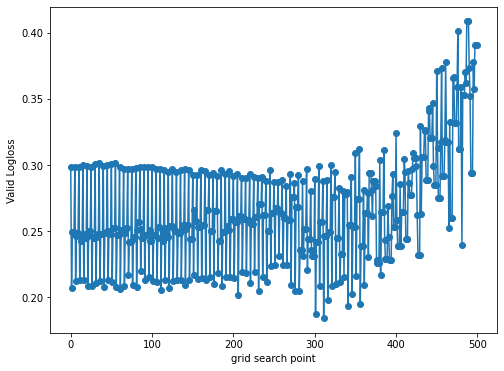

In [199]:
# Plot Loss vs point in grid search
data_out = 'data_xgb_11Radiotherapy'
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_loss.csv'))
fig, axes = plt.subplots(figsize=(8,6))
axes.scatter(df_grid_loss.index, df_grid_loss['valid_loss'])
axes.plot(df_grid_loss.index, df_grid_loss['valid_loss'])
axes.set_xlabel("grid search point")
axes.set_ylabel("Valid Logloss")
plt.show()

In [200]:
# Train with best hyperparameters
param[0] = ('eta', best_eta)
param[1] = ('max_depth', best_depth)

evals_result = {}
xgb_clf = xgb.train(param, dtrain, 
                    num_boost_round = 5000, 
                    evals = valid_list, 
                    early_stopping_rounds = 50, 
                    verbose_eval = True, 
                    evals_result=evals_result)

[0]	train-logloss:0.59202	valid-logloss:0.63378
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[1]	train-logloss:0.49765	valid-logloss:0.57696
[2]	train-logloss:0.41401	valid-logloss:0.52264
[3]	train-logloss:0.36568	valid-logloss:0.48060
[4]	train-logloss:0.31999	valid-logloss:0.45458
[5]	train-logloss:0.27386	valid-logloss:0.41585
[6]	train-logloss:0.23995	valid-logloss:0.39216
[7]	train-logloss:0.20788	valid-logloss:0.37390
[8]	train-logloss:0.18409	valid-logloss:0.35565
[9]	train-logloss:0.16582	valid-logloss:0.33334
[10]	train-logloss:0.15103	valid-logloss:0.30996
[11]	train-logloss:0.13677	valid-logloss:0.29328
[12]	train-logloss:0.12195	valid-logloss:0.28450
[13]	train-logloss:0.10918	valid-logloss:0.26335
[14]	train-logloss:0.09823	valid-logloss:0.24657
[15]	train-logloss:0.08947	valid-logloss:0.24617
[16]	train-logloss:0.08183	valid-logloss:0.23863
[17]	train-logloss:0.07536

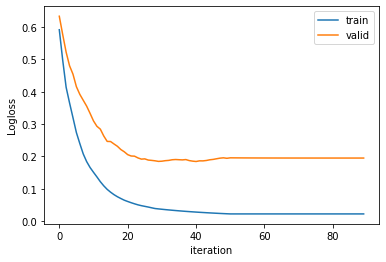

In [201]:
# Plot of train/valid loss vs iter
fig, axes = plt.subplots(figsize=(6,4))
axes.plot(evals_result['train']['logloss'], label="train")
axes.plot(evals_result['valid']['logloss'], label="valid")
axes.legend()
axes.set_ylabel("Logloss")
axes.set_xlabel("iteration")
# axes.set_xticks(np.arange(0, len(evals_result['train']['logloss']), 1))
plt.show()

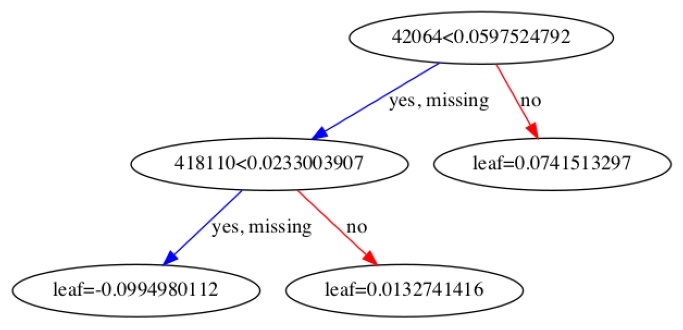

In [202]:
# Plot tree(s)
fig, axes = plt.subplots(figsize=(12,10))
plot_tree(xgb_clf, ax=axes, num_trees=26)
plt.show()

In [203]:
# Save model and model's best params
data_out = 'data_xgb_11Radiotherapy'
xgb_clf.save_model(os.path.join(data_out, 'xgb_model.json'))
print("model saved at: '{}'".format(os.path.join(data_out, 'xgb_model.json')))

best_params = {}
best_params['best_eta'] = best_eta
best_params['best_depth'] = int(best_depth)
with open(os.path.join(data_out, 'xgb_best_params.json'), 'w') as f:
    json.dump(best_params, f)
print("best params saved at: '{}'".format(os.path.join(data_out, 'xgb_best_params.json')))

model saved at: 'data_xgb_11Radiotherapy/xgb_model.json'
best params saved at: 'data_xgb_11Radiotherapy/xgb_best_params.json'


In [204]:
# Save feature map
def ceate_feature_map(features, data_out):
    f = open(os.path.join(data_out, 'xgb_model_fmap.txt'), 'w')
    i = 0
    for feat in features:
        f.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    f.close()

data_out = 'data_xgb_11Radiotherapy'
ceate_feature_map(cols_all, data_out)
print("feature map saved at: '{}'".format(os.path.join(data_out, 'xgb_model_fmap.txt')))

feature map saved at: 'data_xgb_11Radiotherapy/xgb_model_fmap.txt'


In [205]:
# Find MSE, R2, Accuracy, etc...
data_out = 'data_xgb_11Radiotherapy'
model = xgb.Booster(model_file=os.path.join(data_out, 'xgb_model.json'))
df_results = pd.DataFrame(index=['train', 'valid', 'test'], 
                           columns=['accuracy', 'roc_auc'])

ypred = model.predict(dtrain)
ypred = ypred.round().astype(int)
df_results.loc['train', 'accuracy'] = accuracy_score(ytrain, ypred)
df_results.loc['train', 'roc_auc']  = roc_auc_score(ytrain, ypred)

ypred = model.predict(dvalid)
ypred = ypred.round().astype(int)
df_results.loc['valid', 'accuracy'] = accuracy_score(yvalid, ypred)
df_results.loc['valid', 'roc_auc']  = roc_auc_score(yvalid, ypred)

ypred = model.predict(dtest)
ypred = ypred.round().astype(int)
df_results.loc['test', 'accuracy'] = accuracy_score(ytest, ypred)
df_results.loc['test', 'roc_auc']  = roc_auc_score(ytest, ypred)

# Save data
df_results.to_csv(os.path.join(data_out, 'results_target_xgb.csv'), index=True)
print("model results saved at: '{}'".format(os.path.join(data_out, 'results_target_xgb.csv')))
df_results.head()

model results saved at: 'data_xgb_11Radiotherapy/results_target_xgb.csv'


,accuracy,roc_auc
train,1,1
valid,0.935484,0.9375
test,0.90625,0.90625


In [212]:
# Find Accuracy +/- STD
data_in  = 'data_xgb_11Radiotherapy'
data_out = 'data_xgb_11Radiotherapy/partitions'
df_results = pd.DataFrame(columns=['train_acc', 'valid_acc', 'test_acc', 'train_roc', 'valid_roc', 'test_roc'])

with open(os.path.join(data_in, 'xgb_best_params.json')) as f:
    best_params = json.load(f)
param = [('eta', best_params['best_eta']), 
         ('max_depth', best_params['best_depth']), 
         ('objective', 'binary:logistic'), 
         ('nthread', 16),
         ('eval_metric', 'logloss')
]

partitions = 100
iterator = tqdm.notebook.tqdm(range(1, partitions + 1), desc='Partitions loop')
X = pd.read_csv('dataset_11Radiotherapy/X.csv', header=None)
y = pd.read_csv('dataset_11Radiotherapy/y.csv', header=None)
for n in iterator:
    split_data(X, y, seed1=seed1[n], seed2=seed2[n])
    
# .build DMatrices
    dtrain = xgb.DMatrix(data=xtrain, label=ytrain, nthread=16)
    dvalid = xgb.DMatrix(data=xvalid, label=yvalid, nthread=16)
    dtest  = xgb.DMatrix(data=xtest,  label=ytest,  nthread=16)
    valid_list = [(dtrain, 'train'), (dvalid, 'valid')]

# .train model
    evals_result = {}
    model = xgb.train(param, dtrain, 
                      num_boost_round = 5000, 
                      evals = valid_list, 
                      early_stopping_rounds = 20, 
                      verbose_eval = False, 
                      evals_result=evals_result)
    
# .compute/save accuracy
    ypred = model.predict(dtrain)
    ypred = ypred.round().astype(int)
    df_results.loc[n, 'train_acc'] = accuracy_score(ytrain, ypred)
    df_results.loc[n, 'train_roc']  = roc_auc_score(ytrain, ypred)

    ypred = model.predict(dvalid)
    ypred = ypred.round().astype(int)
    df_results.loc[n, 'valid_acc'] = accuracy_score(yvalid, ypred)
    df_results.loc[n, 'valid_roc']  = roc_auc_score(yvalid, ypred)

    ypred = model.predict(dtest)
    ypred = ypred.round().astype(int)
    df_results.loc[n, 'test_acc'] = accuracy_score(ytest, ypred)
    df_results.loc[n, 'test_roc']  = roc_auc_score(ytest, ypred)

    model.save_model(os.path.join(data_out, 'xgb_model_'+str(n)+'.json'))
    df_results.to_csv(os.path.join(data_out, 'accuracy_xgb.csv'), index=None)

Partitions loop:   0%|          | 0/100 [00:00<?, ?it/s]

In [213]:
# Display results
data_out = 'data_xgb_11Radiotherapy'
accuracy_xgb = pd.read_csv(os.path.join(data_out, 'accuracy_xgb.csv'))
print("Train accuracy = {:.3f} +/- {:.3f}".format(accuracy_xgb['train_acc'].mean(), 
                                                  accuracy_xgb['train_acc'].std()))
print("Valid accuracy = {:.3f} +/- {:.3f}".format(accuracy_xgb['valid_acc'].mean(), 
                                                  accuracy_xgb['valid_acc'].std()))
print("Test accuracy = {:.3f} +/- {:.3f}".format(accuracy_xgb['test_acc'].mean(), 
                                                 accuracy_xgb['test_acc'].std()))

Train accuracy = 1.000 +/- 0.000
Valid accuracy = 0.888 +/- 0.067
Test accuracy = 0.887 +/- 0.061


* ### Lockdown

In [22]:
# Normalize Data Set
def normalize_data():
    """
    """
    global xtrain, xvalid, xtest
    scaler = StandardScaler()
    scaler.fit(xtrain.numpy())
    xtrain = torch.from_numpy(scaler.transform(xtrain.numpy()))
    xvalid = torch.from_numpy(scaler.transform(xvalid.numpy()))
    xtest = torch.from_numpy(scaler.transform(xtest.numpy()))

In [23]:
# Save output data
def save_output(data_out, f1, f2, f3, new_folder=False):
    """
    """
# Save relevant data
    if new_folder == True:
        dirs = os.listdir()
        if data_out in dirs:
            print("'{}' directory deleted.".format(data_out))
            shutil.rmtree(data_out)
            print("'{}' directory created.\n".format(data_out))
            os.mkdir(data_out)
        else:
            print("'{}' directory created.\n".format(data_out))
            os.mkdir(data_out)
# 
    train_loss.to_csv(os.path.join(data_out, f1), index=False)
    valid_loss.to_csv(os.path.join(data_out, f2), index=False)
    print("'{}' saved.".format(f1))
    print("'{}' saved.".format(f2))

    for m in f3:
        shutil.move(m, os.path.join(data_out, m))
        print("'{}' saved.".format(m))

* #### l1=5, l2=2; lockdown=l1

In [24]:
# Set layers where lockdown is to be applied
def get_lockdown_layers(model):
    layers = [model.classifier[0]]
    return layers

In [25]:
#  NN architecture with its corresponding forward method
class MyNet(nn.Module):
    
# .Network architecture
    def __init__(self, features, layer_sizes):
        super(MyNet, self).__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(features, layer_sizes[0], bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(layer_sizes[0], layer_sizes[1], bias=True)
        )

# .Forward function
    def forward(self, x):
        x = self.classifier(x)
        return x

In [233]:
# Grid search space
grid_lrs = np.geomspace(5e-4, 5e-2, num=10)
df_grid_loss = pd.DataFrame(columns = ['lr', 'valid_loss', 'valid_acc'], 
                            index=range(len(grid_lrs)))

In [234]:
# Perform grid search (unconstrained)
layer_sizes = [5, 2]
epochs = 20000
data_in = 'dataset_11Radiotherapy'
data_out = "data_unconstrained_11Radiotherapy/lrs"
lock_flag = False

# Read data
load_data(data_in)

# Normalize data
normalize_data()

# Create DataLoaders
make_DataLoaders()
features = xtrain.size(1)

# Train model
iterator = tqdm.notebook.tqdm(range(1, len(grid_lrs) + 1), desc='lr-grid loop')
for n in iterator:
    irow = n-1
    fname = 'model11_forward05_'+str(n)
    train_loss, valid_loss = train_model(
                             grid_lrs[irow], 
                             features, 
                             layer_sizes,
                             lock_flag = lock_flag,
                             epochs=epochs,
                             early_stop=epochs, 
                             fname=fname)
    print('\nBest train loss = {:.7f}\n'.format(train_loss['loss'].min()))

# .save relevant data
    f3 = [fname+'_last.pth', fname+'_best.pth']
    save_output(data_out, 
                'train_loss05_'+str(n)+'.csv', 
                'valid_loss05_'+str(n)+'.csv', f3)
    
# .find MSE, R2, etc...
    mm = MyNet(features, layer_sizes)
    mm.load_state_dict(torch.load(os.path.join(data_out, fname+'_best.pth')))
    mm = mm.to(device)
    mm.eval()

# .save grid search results
    ypred = mm(xvalid)
    loss = loss_type(ypred, yvalid.view(-1))
    accu = dataset_accuracy(valid_dataloader, mm, device)
    df_grid_loss.iloc[irow,:] = [grid_lrs[irow], loss.detach().item(), accu]
    df_grid_loss.to_csv(os.path.join(data_out, 'df_grid_forward05.csv'), index=None)

- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


lr-grid loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00050
-Model saved after iteration 272.
-Train.  Loss=0.0730791
-Valid.  Loss=0.3257526

Best train loss = 0.0149676

'train_loss05_1.csv' saved.
'valid_loss05_1.csv' saved.
'model11_forward05_1_last.pth' saved.
'model11_forward05_1_best.pth' saved.


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-Model saved after iteration 701.
-Train.  Loss=0.0497148
-Valid.  Loss=0.2207381

Best train loss = 0.0001750

'train_loss05_2.csv' saved.
'valid_loss05_2.csv' saved.
'model11_forward05_2_last.pth' saved.
'model11_forward05_2_best.pth' saved.


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00139
-Model saved after iteration 191.
-Train.  Loss=0.0368455
-Valid.  Loss=0.4606292

Best train loss = 0.0001048

'train_loss05_3.csv' saved.
'valid_loss05_3.csv' saved.
'model11_forward05_3_last.pth' saved.
'model11_forward05_3_best.pth' saved.


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00232
-Model saved after iteration 94.
-Train.  Loss=0.0525662
-Valid.  Loss=0.2899057

Best train loss = 0.0042455

'train_loss05_4.csv' saved.
'valid_loss05_4.csv' saved.
'model11_forward05_4_last.pth' saved.
'model11_forward05_4_best.pth' saved.


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00387
-Model saved after iteration 18.
-Train.  Loss=0.1145675
-Valid.  Loss=0.5029849

Best train loss = 0.0000314

'train_loss05_5.csv' saved.
'valid_loss05_5.csv' saved.
'model11_forward05_5_last.pth' saved.
'model11_forward05_5_best.pth' saved.


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00646
-Model saved after iteration 103.
-Train.  Loss=0.0090201
-Valid.  Loss=0.6597723

Best train loss = 0.0000153

'train_loss05_6.csv' saved.
'valid_loss05_6.csv' saved.
'model11_forward05_6_last.pth' saved.
'model11_forward05_6_best.pth' saved.


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.01077
-Model saved after iteration 1.
-Train.  Loss=0.7396039
-Valid.  Loss=0.7524709

Best train loss = 0.0023782

'train_loss05_7.csv' saved.
'valid_loss05_7.csv' saved.
'model11_forward05_7_last.pth' saved.
'model11_forward05_7_best.pth' saved.


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.01797
-Model saved after iteration 1.
-Train.  Loss=0.7225013
-Valid.  Loss=0.7194833

Best train loss = 0.0014254

'train_loss05_8.csv' saved.
'valid_loss05_8.csv' saved.
'model11_forward05_8_last.pth' saved.
'model11_forward05_8_best.pth' saved.


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 64.
-Train.  Loss=0.0337897
-Valid.  Loss=0.2567480

Best train loss = 0.0008359

'train_loss05_9.csv' saved.
'valid_loss05_9.csv' saved.
'model11_forward05_9_last.pth' saved.
'model11_forward05_9_best.pth' saved.


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05000
-Model saved after iteration 1.
-Train.  Loss=0.7355057
-Valid.  Loss=0.6893207

Best train loss = 0.0005050

'train_loss05_10.csv' saved.
'valid_loss05_10.csv' saved.
'model11_forward05_10_last.pth' saved.
'model11_forward05_10_best.pth' saved.


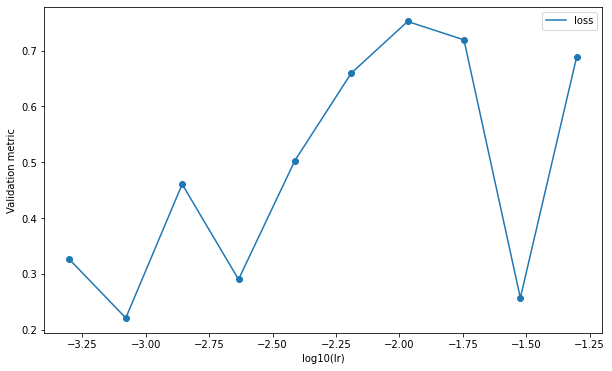

In [251]:
# Plot Loss vs point in grid search
data_out = "data_unconstrained_11Radiotherapy/lrs"
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_forward05.csv'))
fig, axes = plt.subplots(figsize=(10,6))
axes.scatter(np.log10(df_grid_loss.lr), df_grid_loss['valid_loss'])
axes.plot(np.log10(df_grid_loss.lr), df_grid_loss['valid_loss'], label='loss')
# axes.scatter(np.log10(df_grid_loss.lr), df_grid_loss['valid_r2'])
# axes.plot(np.log10(df_grid_loss.lr), df_grid_loss['valid_r2'], label='r2')
axes.set_xlabel("log10(lr)")
axes.set_ylabel("Validation metric")
axes.legend()
plt.show()

In [252]:
# Display grid search results
data_out = "data_unconstrained_11Radiotherapy/lrs"
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_forward05.csv'))

idx = df_grid_loss.valid_loss.idxmin()
best_lr_fward = df_grid_loss.iloc[idx, 0]
best_mse      = df_grid_loss.iloc[idx, 1]
print("Best parameters ({}):".format(idx+1))
print("- Best lr = {:.5f}".format(best_lr_fward))
print("- Best valid loss = {}".format(best_mse))

# Copy best model to main directory
shutil.copy("data_unconstrained_11Radiotherapy/lrs/model11_forward05_"+str(idx+1)+"_best.pth", 
            "data_unconstrained_11Radiotherapy/model11_forward05_best.pth")
shutil.copy("data_unconstrained_11Radiotherapy/lrs/model11_forward05_"+str(idx+1)+"_last.pth", 
            "data_unconstrained_11Radiotherapy/model11_forward05_last.pth")

shutil.copy("data_unconstrained_11Radiotherapy/lrs/train_loss05_"+str(idx+1)+".csv", 
            "data_unconstrained_11Radiotherapy/train_loss05.csv")
shutil.copy("data_unconstrained_11Radiotherapy/lrs/valid_loss05_"+str(idx+1)+".csv", 
            "data_unconstrained_11Radiotherapy/valid_loss05.csv")

Best parameters (2):
- Best lr = 0.00083
- Best valid loss = 0.22073815762996676


'data_unconstrained_11Radiotherapy/valid_loss05.csv'

In [239]:
# Grid search space
grid_lrs = np.geomspace(5e-4, 5e-2, num=10)
df_grid_loss = pd.DataFrame(columns = ['lr', 'valid_loss', 'valid_acc'], 
                            index=range(len(grid_lrs)))

In [240]:
# Perform grid search (lockdown: path 2)
layer_sizes = [5, 2]
epochs = 10000
data_in = 'dataset_11Radiotherapy'
data_out = "data_lockdown_11Radiotherapy/lrs"
lock_flag = True
step = 1

# Read data
load_data(data_in)

# Normalize data
normalize_data()

# Create DataLoaders
make_DataLoaders()
features = xtrain.size(1)

# Train model
iterator = tqdm.notebook.tqdm(range(1, len(grid_lrs) + 1), desc='lr-grid loop')
for n in iterator:
    irow = n-1
    model_forward_name = 'data_unconstrained_11Radiotherapy/lrs/model11_forward05_'+str(n)+'_last.pth'
    fname = 'model11_backward05_'+str(n)
    train_loss, valid_loss = train_model(
                             grid_lrs[irow], 
                             features, 
                             layer_sizes,
                             lock_flag = lock_flag,
                             epochs=epochs,
                             early_stop=epochs, 
                             fname=fname)
    print('\nBest train loss = {:.7f}\n'.format(train_loss['loss'].min()))

# .save relevant data
    f3 = [fname+'_best.pth']
    save_output(data_out, 
                'train_loss05_'+str(n)+'.csv', 
                'valid_loss05_'+str(n)+'.csv', f3)
    
# .find MSE, R2, etc...
    mm = MyNet(features, layer_sizes)
    mm.load_state_dict(torch.load(os.path.join(data_out, fname+'_best.pth')))
    mm = mm.to(device)
    mm.eval()

# .save grid search results
    ypred = mm(xvalid)
    loss = loss_type(ypred, yvalid.view(-1))
    accu = dataset_accuracy(valid_dataloader, mm, device)
    df_grid_loss.iloc[irow,:] = [grid_lrs[irow], loss.detach().item(), accu]
    df_grid_loss.to_csv(os.path.join(data_out, 'df_grid_backward05.csv'), index=None)

- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


lr-grid loop:   0%|          | 0/10 [00:00<?, ?it/s]

Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00050
-Model saved after iteration 10000.
-Train.  Loss=0.0605777
-Valid.  Loss=0.2926506

Best train loss = 0.0137832

'train_loss05_1.csv' saved.
'valid_loss05_1.csv' saved.
'model11_backward05_1_best.pth' saved.


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-Model saved after iteration 10000.
-Train.  Loss=0.0294446
-Valid.  Loss=0.4010619

Best train loss = 0.0000000

'train_loss05_2.csv' saved.
'valid_loss05_2.csv' saved.
'model11_backward05_2_best.pth' saved.


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00139
-Model saved after iteration 9752.
-Train.  Loss=0.0591627
-Valid.  Loss=0.3011671

Best train loss = 0.0000000

'train_loss05_3.csv' saved.
'valid_loss05_3.csv' saved.
'model11_backward05_3_best.pth' saved.


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00232
-Model saved after iteration 9817.
-Train.  Loss=0.0842750
-Valid.  Loss=0.3336459

Best train loss = 0.0000000

'train_loss05_4.csv' saved.
'valid_loss05_4.csv' saved.
'model11_backward05_4_best.pth' saved.


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00387
-Model saved after iteration 9789.
-Train.  Loss=0.0715348
-Valid.  Loss=0.3789994

Best train loss = 0.0000000

'train_loss05_5.csv' saved.
'valid_loss05_5.csv' saved.
'model11_backward05_5_best.pth' saved.


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00646
-Model saved after iteration 9755.
-Train.  Loss=0.1237884
-Valid.  Loss=0.2664996

Best train loss = 0.0000000

'train_loss05_6.csv' saved.
'valid_loss05_6.csv' saved.
'model11_backward05_6_best.pth' saved.


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.01077
-Model saved after iteration 9737.
-Train.  Loss=0.2823010
-Valid.  Loss=0.2913175

Best train loss = 0.0000002

'train_loss05_7.csv' saved.
'valid_loss05_7.csv' saved.
'model11_backward05_7_best.pth' saved.


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.01797
-Model saved after iteration 7237.
-Train.  Loss=0.0041282
-Valid.  Loss=0.2643746

Best train loss = 0.0000000

'train_loss05_8.csv' saved.
'valid_loss05_8.csv' saved.
'model11_backward05_8_best.pth' saved.


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 6699.
-Train.  Loss=0.0167302
-Valid.  Loss=0.2454522

Best train loss = 0.0000002

'train_loss05_9.csv' saved.
'valid_loss05_9.csv' saved.
'model11_backward05_9_best.pth' saved.


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.05000
-Model saved after iteration 1.
-Train.  Loss=0.0005050
-Valid.  Loss=995381957623808.0000000

Best train loss = 0.0003357

'train_loss05_10.csv' saved.
'valid_loss05_10.csv' saved.
'model11_backward05_10_best.pth' saved.


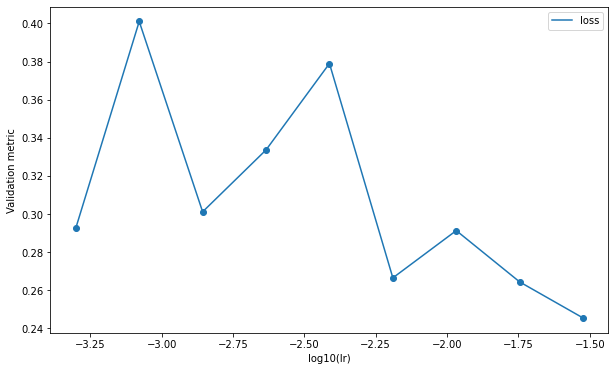

In [254]:
# Plot Loss vs point in grid search
data_out = "data_lockdown_11Radiotherapy/lrs"
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_backward05.csv'))
fig, axes = plt.subplots(figsize=(10,6))
axes.scatter(np.log10(df_grid_loss.lr), df_grid_loss['valid_loss'])
axes.plot(np.log10(df_grid_loss.lr), df_grid_loss['valid_loss'], label='loss')
# axes.scatter(np.log10(df_grid_loss.lr), df_grid_loss['valid_r2'])
# axes.plot(np.log10(df_grid_loss.lr), df_grid_loss['valid_r2'], label='r2')
axes.set_xlabel("log10(lr)")
axes.set_ylabel("Validation metric")
axes.legend()
plt.show()

In [255]:
# Display grid search results
data_out = "data_lockdown_11Radiotherapy/lrs"
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_backward05.csv'))

idx = df_grid_loss.valid_loss.idxmin()
best_lr_bward = df_grid_loss.iloc[idx, 0]
best_mse      = df_grid_loss.iloc[idx, 1]
print("Best parameters ({}):".format(idx+1))
print("- Best lr = {:.5f}".format(best_lr_bward))
print("- Best valid loss = {}".format(best_mse))

# Copy best models to main directory
shutil.copy("data_unconstrained_11Radiotherapy/lrs/model11_forward05_"+str(idx+1)+"_best.pth", 
            "data_lockdown_11Radiotherapy/model11_fward05_best.pth")
shutil.copy("data_unconstrained_11Radiotherapy/lrs/model11_forward05_"+str(idx+1)+"_last.pth", 
            "data_lockdown_11Radiotherapy/model11_fward05_last.pth")
shutil.copy("data_lockdown_11Radiotherapy/lrs/model11_backward05_"+str(idx+1)+"_best.pth", 
            "data_lockdown_11Radiotherapy/model11_backward05_best.pth")

shutil.copy("data_unconstrained_11Radiotherapy/lrs/train_loss05_"+str(idx+1)+".csv", 
            "data_lockdown_11Radiotherapy/train_loss_fward05.csv")
shutil.copy("data_unconstrained_11Radiotherapy/lrs/valid_loss05_"+str(idx+1)+".csv", 
            "data_lockdown_11Radiotherapy/valid_loss_fward05.csv")
shutil.copy("data_lockdown_11Radiotherapy/lrs/train_loss05_"+str(idx+1)+".csv", 
            "data_lockdown_11Radiotherapy/train_loss05.csv")
shutil.copy("data_lockdown_11Radiotherapy/lrs/valid_loss05_"+str(idx+1)+".csv", 
            "data_lockdown_11Radiotherapy/valid_loss05.csv")

Best parameters (9):
- Best lr = 0.02997
- Best valid loss = 0.245452255


'data_lockdown_11Radiotherapy/valid_loss05.csv'

In [256]:
# Find Loss, Accuracy, etc...
data_out = "data_lockdown_11Radiotherapy"
index = pd.MultiIndex.from_product([['TRAIN', 'VALIDATION', 'TEST'], ['forward', 'lockdown']])
df_results = pd.DataFrame(index=index, columns=['LOSS', 'ACCURACY'])

# Unconstrained results
mm = MyNet(features, layer_sizes)
mm.load_state_dict(torch.load('data_unconstrained_11Radiotherapy/model11_forward05_best.pth'))
mm = mm.to(device)
mm.eval()

ypred = mm(xtrain)
loss = loss_type(ypred, ytrain.view(-1))
accu = dataset_accuracy(train_dataloader, mm, device)
df_results.loc[('TRAIN', 'forward'), 'LOSS'] = loss.detach().item()
df_results.loc[('TRAIN', 'forward'), 'ACCURACY'] = accu

ypred = mm(xvalid)
loss = loss_type(ypred, yvalid.view(-1))
accu = dataset_accuracy(valid_dataloader, mm, device)
df_results.loc[('VALIDATION', 'forward'), 'LOSS'] = loss.detach().item()
df_results.loc[('VALIDATION', 'forward'), 'ACCURACY'] = accu

ypred = mm(xtest)
loss = loss_type(ypred, ytest.view(-1))
accu = dataset_accuracy(test_dataloader, mm, device)
df_results.loc[('TEST', 'forward'), 'LOSS'] = loss.detach().item()
df_results.loc[('TEST', 'forward'), 'ACCURACY'] = accu

# Lockdown results
mm = MyNet(features, layer_sizes)
mm.load_state_dict(torch.load('data_lockdown_11Radiotherapy/model11_backward05_best.pth'))
mm = mm.to(device)
mm.eval()

ypred = mm(xtrain)
loss = loss_type(ypred, ytrain.view(-1))
accu = dataset_accuracy(train_dataloader, mm, device)
df_results.loc[('TRAIN', 'lockdown'), 'LOSS'] = loss.detach().item()
df_results.loc[('TRAIN', 'lockdown'), 'ACCURACY'] = accu

ypred = mm(xvalid)
loss = loss_type(ypred, yvalid.view(-1))
accu = dataset_accuracy(valid_dataloader, mm, device)
df_results.loc[('VALIDATION', 'lockdown'), 'LOSS'] = loss.detach().item()
df_results.loc[('VALIDATION', 'lockdown'), 'ACCURACY'] = accu

ypred = mm(xtest)
loss = loss_type(ypred, ytest.view(-1))
accu = dataset_accuracy(test_dataloader, mm, device)
df_results.loc[('TEST', 'lockdown'), 'LOSS'] = loss.detach().item()
df_results.loc[('TEST', 'lockdown'), 'ACCURACY'] = accu

df_results.to_csv(os.path.join(data_out, 'results05.csv'), index=True)
df_results

LOSS  ACCURACY
TRAIN      forward   0.0497148  0.989247
           lockdown  0.0167302         1
VALIDATION forward    0.220738  0.935484
           lockdown   0.245452  0.935484
TEST       forward    0.319842     0.875
           lockdown   0.263531    0.9375

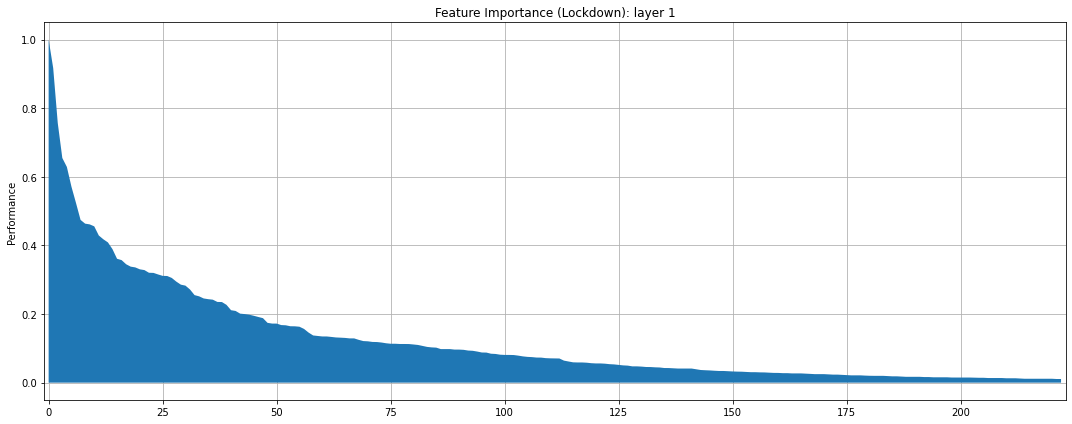

Feature importance graph saved at: 'data_lockdown_11Radiotherapy/feature_importance05.pdf'
feature importance .csv saved at: 'data_lockdown_11Radiotherapy/feature_importance_lockdown05.csv'


In [13]:
# Weight importance (Lockdown: layer 1)
layer_sizes = [5, 2]
data_out = "data_lockdown_11Radiotherapy"
m1 = torch.load('data_lockdown_11Radiotherapy/model11_backward05_best.pth')
feature_importance1 = pd.Series(abs(m1['classifier.0.weight']).sum(dim=0), index=cols_all)
feature_importance1 = feature_importance1/feature_importance1.max()
feature_importance_sorted1 = feature_importance1.sort_values(ascending=False)

idx = feature_importance_sorted1 > 1e-2

fig, axes = plt.subplots(figsize=(15,6))
x_pos = np.arange(idx.sum())
axes.fill_between(x_pos, 0, feature_importance_sorted1[idx], zorder=2)
# axes.set_xticks(x_pos)
# axes.set_xticklabels(feature_importance_sorted1.index[idx], rotation='vertical')
axes.set_xlim(-1,idx.sum())
axes.set_ylabel('Performance')
axes.set_title('Feature Importance (Lockdown): layer 1')
axes.grid(True, zorder=1)

plt.tight_layout()
plt.savefig(os.path.join(data_out, 'feature_importance05.pdf'), bbox_inches='tight')
plt.show()
print("Feature importance graph saved at: '{}'".format(os.path.join(data_out, 'feature_importance05.pdf')))

feature_importance_sorted1.to_csv(os.path.join(data_out, 'feature_importance_lockdown05.csv'))
print("feature importance .csv saved at: '{}'".format(os.path.join(data_out, 
                                                                   'feature_importance_lockdown05.csv')))

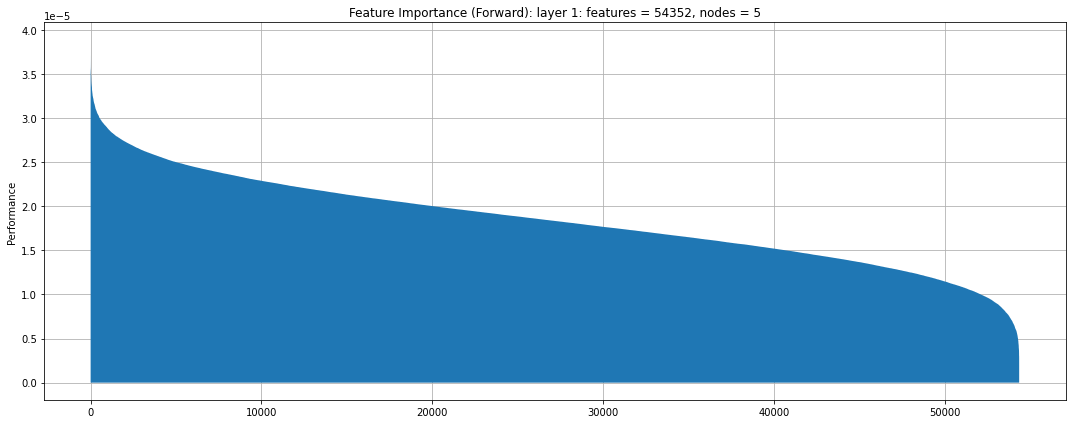

Feature importance graph saved at: 'data_unconstrained_11Radiotherapy/feature_importance05.pdf'
feature importance .csv saved at: 'data_unconstrained_11Radiotherapy/feature_importance_forward05.csv'


In [39]:
# Weight importance (Forward: layer 1)
layer_sizes = [5, 2]
data_out = "data_unconstrained_11Radiotherapy"
m1 = torch.load('data_unconstrained_11Radiotherapy/model11_forward05_best.pth')
feature_importance1 = pd.Series(abs(m1['classifier.0.weight']).sum(dim=0), index=cols_all)
feature_importance1 = feature_importance1/feature_importance1.sum()
feature_importance_sorted1 = feature_importance1.sort_values(ascending=False)

idx = feature_importance_sorted1 >= 0

fig, axes = plt.subplots(figsize=(15,6))
x_pos = np.arange(idx.sum())
axes.fill_between(x_pos, 0, feature_importance_sorted1[idx], zorder=2, lw=3)
# axes.set_xticks(x_pos)
# axes.set_xticklabels(feature_importance_sorted1.index[idx], rotation='vertical')
# axes.set_xlim(-1,idx.sum())
axes.set_ylabel('Performance')
axes.set_title('Feature Importance (Forward): layer 1: features = {}, nodes = {}'.format(n_features, 
                                                                                          layer_sizes[0]))
axes.grid(True, zorder=1)

plt.tight_layout()
plt.savefig(os.path.join(data_out, 'feature_importance05.pdf'), bbox_inches='tight')
plt.show()
print("Feature importance graph saved at: '{}'".format(os.path.join(data_out, 'feature_importance05.pdf')))

feature_importance_sorted1.to_csv(os.path.join(data_out, 'feature_importance_forward05.csv'))
print("feature importance .csv saved at: '{}'".format(os.path.join(data_out, 'feature_importance_forward05.csv')))

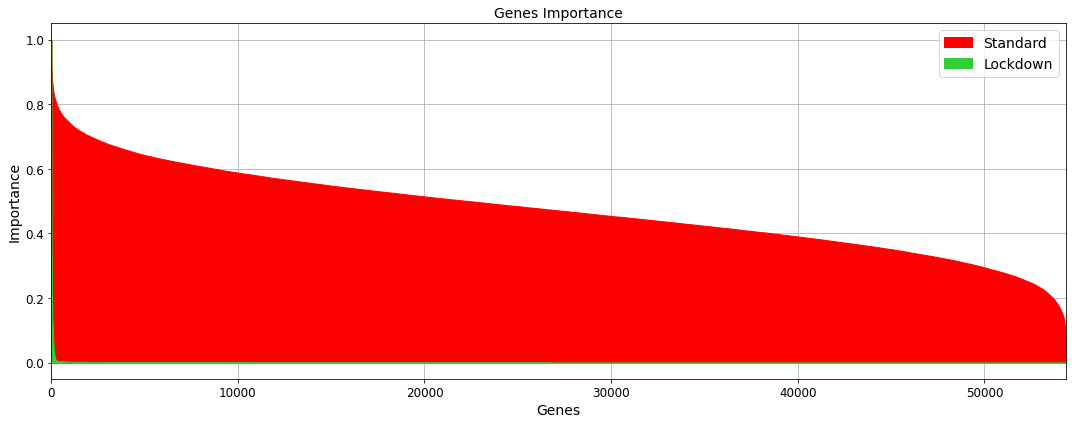

In [6]:
# Gene importance
data_out = "data_lockdown_11Radiotherapy"
m1 = torch.load('data_lockdown_11Radiotherapy/model11_backward05_best.pth')
feature_importance1 = pd.Series(abs(m1['classifier.0.weight']).sum(dim=0), index=cols_all)
feature_importance1 = feature_importance1/feature_importance1.max()
feature_importance_sorted1 = feature_importance1.sort_values(ascending=False)
idx1 = feature_importance_sorted1 >= 0

data_out = "data_unconstrained_11Radiotherapy"
m2 = torch.load('data_unconstrained_11Radiotherapy/model11_forward05_best.pth')
feature_importance2 = pd.Series(abs(m2['classifier.0.weight']).sum(dim=0), index=cols_all)
feature_importance2 = feature_importance2/feature_importance2.max()
feature_importance_sorted2 = feature_importance2.sort_values(ascending=False)
idx2 = feature_importance_sorted2 >= 0

fig, axes = plt.subplots(figsize=(15,6))
x_pos = np.arange(idx2.sum())
axes.fill_between(x_pos, 0, feature_importance_sorted2[idx2], label='Standard', zorder=2, color='red')
axes.fill_between(x_pos, 0, feature_importance_sorted1[idx1], label='Lockdown', zorder=2, color='limegreen')
axes.set_xlim(-1,idx2.sum())
axes.set_ylabel('Importance', fontsize=14)
axes.set_xlabel('Genes', fontsize=14)
# axes.set_title('Genes Importance: genes = {}'.format(features), fontsize=14)
axes.set_title('Genes Importance', fontsize=14)
axes.legend(fontsize=14)
axes.grid(True, zorder=1)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join("data_lockdown_11Radiotherapy", 'feature_importance.pdf'), bbox_inches='tight')
plt.show()
# print("Feature importance graph saved at: '{}'".format(os.path.join(data_out, 'feature_importance05.pdf')))

# feature_importance_sorted1.to_csv(os.path.join(data_out, 'feature_importance_lockdown05.csv'))
# print("feature importance .csv saved at: '{}'".format(os.path.join(data_out, 'feature_importance_lockdown05.csv')))

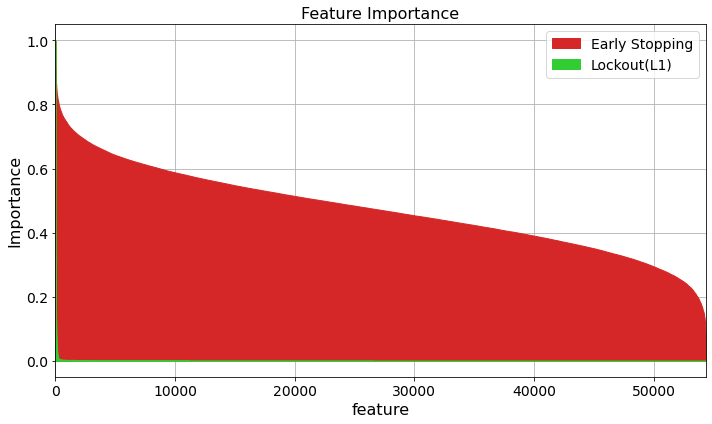

In [52]:
# Gene importance
data_out = "data_lockdown_11Radiotherapy"
m1 = torch.load('data_lockdown_11Radiotherapy/model11_backward05_best.pth')
feature_importance1 = pd.Series(abs(m1['classifier.0.weight']).sum(dim=0), index=cols_all)
feature_importance1 = feature_importance1/feature_importance1.max()
feature_importance_sorted1 = feature_importance1.sort_values(ascending=False)
idx1 = feature_importance_sorted1 >= 0

data_out = "data_unconstrained_11Radiotherapy"
m2 = torch.load('data_unconstrained_11Radiotherapy/model11_forward05_best.pth')
feature_importance2 = pd.Series(abs(m2['classifier.0.weight']).sum(dim=0), index=cols_all)
feature_importance2 = feature_importance2/feature_importance2.max()
feature_importance_sorted2 = feature_importance2.sort_values(ascending=False)
idx2 = feature_importance_sorted2 >= 0

fig, axes = plt.subplots(figsize=(10,6))
x_pos = np.arange(idx2.sum())
axes.fill_between(x_pos, 0, feature_importance_sorted2[idx2], label='Early Stopping', 
                  zorder=2, color='tab:red')
axes.fill_between(x_pos, 0, feature_importance_sorted1[idx1], label='Lockout(L1)', 
                  zorder=2, color='limegreen')
axes.set_xlim(-1,idx2.sum())
axes.set_ylabel('Importance', fontsize=16)
axes.set_xlabel('feature', fontsize=16)
# axes.set_title('Genes Importance: genes = {}'.format(features), fontsize=14)
axes.set_title('Feature Importance', fontsize=16)
axes.legend(fontsize=14)
axes.grid(True, zorder=1)
axes.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.savefig(os.path.join("data_lockdown_11Radiotherapy", 'feature_importance_2.pdf'), bbox_inches='tight')
plt.show()
# print("Feature importance graph saved at: '{}'".format(os.path.join(data_out, 'feature_importance05.pdf')))

In [265]:
# Find Accuracy, Loss +/- STD (Forward)
data_output = 'data_unconstrained_11Radiotherapy'
accuracy_forward = pd.DataFrame(columns=['train_acc', 'valid_acc', 'test_acc', 
                                         'train_loss', 'valid_loss', 'test_loss'])

partitions = 100
iterator = tqdm.notebook.tqdm(range(1, partitions + 1), desc='Partitions loop')
for n in iterator:
    X = pd.read_csv('dataset_11Radiotherapy/X.csv', header=None)
    y = pd.read_csv('dataset_11Radiotherapy/y.csv', header=None)
    split_data(X, y, seed1=seed1[n], seed2=seed2[n])

# .normalize data sets
    df_to_tensor()
    normalize_data()
    make_DataLoaders()

# .train model (forward)
    lr = best_lr_fward
    layer_sizes = [5, 2]
    epochs = 20000
    data_out = "data_unconstrained_11Radiotherapy/partitions"
    lock_flag = False
    features = xtrain.size(1)
    fname = 'model11_forward05_'+str(n)
    train_loss, valid_loss = train_model(
                             lr, 
                             features, 
                             layer_sizes,
                             lock_flag = lock_flag,
                             epochs = epochs,
                             early_stop = 4000, 
                             fname = fname)
# .save relevant data
    f3 = [fname+'_last.pth', fname+'_best.pth']
    save_output(data_out, 
                'train_loss05_'+str(n)+'.csv', 
                'valid_loss05_'+str(n)+'.csv', f3)

# .find Loss, Accurary, etc...
    mm = MyNet(features, layer_sizes)
    mm.load_state_dict(torch.load(os.path.join(data_out, fname+'_best.pth')))
    mm = mm.to(device)
    mm.eval()
    
    ypred = mm(xtrain)
    loss = loss_type(ypred, ytrain.view(-1))
    accu = dataset_accuracy(train_dataloader, mm, device)
    accuracy_forward.loc[n, 'train_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'train_acc'] = accu

    ypred = mm(xvalid)
    loss = loss_type(ypred, yvalid.view(-1))
    accu = dataset_accuracy(valid_dataloader, mm, device)
    accuracy_forward.loc[n, 'valid_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'valid_acc'] = accu

    ypred = mm(xtest)
    loss = loss_type(ypred, ytest.view(-1))
    accu = dataset_accuracy(test_dataloader, mm, device)
    accuracy_forward.loc[n, 'test_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'test_acc'] = accu

    accuracy_forward.to_csv(os.path.join(data_out, 'accuracy11_forward05.csv'), index=True)

Partitions loop:   0%|          | 0/100 [00:00<?, ?it/s]

- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 63.
-Train.  Loss=0.1335604
-Valid.  Loss=0.5149336
'train_loss05_1.csv' saved.
'valid_loss05_1.csv' saved.
'model11_forward05_1_last.pth' saved.
'model11_forward05_1_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-Model saved after iteration 20000.
-Train.  Loss=0.0324949
-Valid.  Loss=0.1404966
'train_loss05_2.csv' saved.
'valid_loss05_2.csv' saved.
'model11_forward05_2_last.pth' saved.
'model11_forward05_2_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-Model saved after iteration 20000.
-Train.  Loss=0.0129125
-Valid.  Loss=0.0953405
'train_loss05_3.csv' saved.
'valid_loss05_3.csv' saved.
'model11_forward05_3_last.pth' saved.
'model11_forward05_3_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-Model saved after iteration 19935.
-Train.  Loss=0.0191420
-Valid.  Loss=0.1291979
'train_loss05_4.csv' saved.
'valid_loss05_4.csv' saved.
'model11_forward05_4_last.pth' saved.
'model11_forward05_4_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 105.
-Train.  Loss=0.1388262
-Valid.  Loss=0.5422871
'train_loss05_5.csv' saved.
'valid_loss05_5.csv' saved.
'model11_forward05_5_last.pth' saved.
'model11_forward05_5_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 25.
-Train.  Loss=0.3662592
-Valid.  Loss=0.5554268
'train_loss05_6.csv' saved.
'valid_loss05_6.csv' saved.
'model11_forward05_6_last.pth' saved.
'model11_forward05_6_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 3813.
-Train.  Loss=0.0016796
-Valid.  Loss=0.3205439
'train_loss05_7.csv' saved.
'valid_loss05_7.csv' saved.
'model11_forward05_7_last.pth' saved.
'model11_forward05_7_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 3155.
-Train.  Loss=0.0016855
-Valid.  Loss=0.2257426
'train_loss05_8.csv' saved.
'valid_loss05_8.csv' saved.
'model11_forward05_8_last.pth' saved.
'model11_forward05_8_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-Model saved after iteration 20000.
-Train.  Loss=0.0001783
-Valid.  Loss=0.0561803
'train_loss05_9.csv' saved.
'valid_loss05_9.csv' saved.
'model11_forward05_9_last.pth' saved.
'model11_forward05_9_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 833.
-Train.  Loss=0.1098945
-Valid.  Loss=0.3726572
'train_loss05_10.csv' saved.
'valid_loss05_10.csv' saved.
'model11_forward05_10_last.pth' saved.
'model11_forward05_10_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 151.
-Train.  Loss=0.2273855
-Valid.  Loss=0.6007250
'train_loss05_11.csv' saved.
'valid_loss05_11.csv' saved.
'model11_forward05_11_last.pth' saved.
'model11_forward05_11_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 828.
-Train.  Loss=0.0716162
-Valid.  Loss=0.4090062
'train_loss05_12.csv' saved.
'valid_loss05_12.csv' saved.
'model11_forward05_12_last.pth' saved.
'model11_forward05_12_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 2076.
-Train.  Loss=0.0080496
-Valid.  Loss=0.3071591
'train_loss05_13.csv' saved.
'valid_loss05_13.csv' saved.
'model11_forward05_13_last.pth' saved.
'model11_forward05_13_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 594.
-Train.  Loss=0.0308108
-Valid.  Loss=0.4506240
'train_loss05_14.csv' saved.
'valid_loss05_14.csv' saved.
'model11_forward05_14_last.pth' saved.
'model11_forward05_14_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 484.
-Train.  Loss=0.0232917
-Valid.  Loss=0.3826814
'train_loss05_15.csv' saved.
'valid_loss05_15.csv' saved.
'model11_forward05_15_last.pth' saved.
'model11_forward05_15_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 1390.
-Train.  Loss=0.1140697
-Valid.  Loss=0.2926486
'train_loss05_16.csv' saved.
'valid_loss05_16.csv' saved.
'model11_forward05_16_last.pth' saved.
'model11_forward05_16_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-Model saved after iteration 19909.
-Train.  Loss=0.0255618
-Valid.  Loss=0.1854184
'train_loss05_17.csv' saved.
'valid_loss05_17.csv' saved.
'model11_forward05_17_last.pth' saved.
'model11_forward05_17_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-Model saved after iteration 20000.
-Train.  Loss=0.0001897
-Valid.  Loss=0.0412369
'train_loss05_18.csv' saved.
'valid_loss05_18.csv' saved.
'model11_forward05_18_last.pth' saved.
'model11_forward05_18_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 10715.
-Train.  Loss=0.0004269
-Valid.  Loss=0.1578191
'train_loss05_19.csv' saved.
'valid_loss05_19.csv' saved.
'model11_forward05_19_last.pth' saved.
'model11_forward05_19_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 736.
-Train.  Loss=0.0136777
-Valid.  Loss=0.2386154
'train_loss05_20.csv' saved.
'valid_loss05_20.csv' saved.
'model11_forward05_20_last.pth' saved.
'model11_forward05_20_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 1448.
-Train.  Loss=0.0348556
-Valid.  Loss=0.3561080
'train_loss05_21.csv' saved.
'valid_loss05_21.csv' saved.
'model11_forward05_21_last.pth' saved.
'model11_forward05_21_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 317.
-Train.  Loss=0.1098043
-Valid.  Loss=0.5708882
'train_loss05_22.csv' saved.
'valid_loss05_22.csv' saved.
'model11_forward05_22_last.pth' saved.
'model11_forward05_22_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 636.
-Train.  Loss=0.0314202
-Valid.  Loss=0.2747200
'train_loss05_23.csv' saved.
'valid_loss05_23.csv' saved.
'model11_forward05_23_last.pth' saved.
'model11_forward05_23_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 317.
-Train.  Loss=0.1289121
-Valid.  Loss=0.5894797
'train_loss05_24.csv' saved.
'valid_loss05_24.csv' saved.
'model11_forward05_24_last.pth' saved.
'model11_forward05_24_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 647.
-Train.  Loss=0.0945405
-Valid.  Loss=0.2996541
'train_loss05_25.csv' saved.
'valid_loss05_25.csv' saved.
'model11_forward05_25_last.pth' saved.
'model11_forward05_25_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 73.
-Train.  Loss=0.2111995
-Valid.  Loss=0.4749172
'train_loss05_26.csv' saved.
'valid_loss05_26.csv' saved.
'model11_forward05_26_last.pth' saved.
'model11_forward05_26_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 87.
-Train.  Loss=0.0932707
-Valid.  Loss=0.5938113
'train_loss05_27.csv' saved.
'valid_loss05_27.csv' saved.
'model11_forward05_27_last.pth' saved.
'model11_forward05_27_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 1909.
-Train.  Loss=0.0156588
-Valid.  Loss=0.2568664
'train_loss05_28.csv' saved.
'valid_loss05_28.csv' saved.
'model11_forward05_28_last.pth' saved.
'model11_forward05_28_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 50.
-Train.  Loss=0.2946023
-Valid.  Loss=0.6033328
'train_loss05_29.csv' saved.
'valid_loss05_29.csv' saved.
'model11_forward05_29_last.pth' saved.
'model11_forward05_29_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 49.
-Train.  Loss=0.2714553
-Valid.  Loss=0.4989989
'train_loss05_30.csv' saved.
'valid_loss05_30.csv' saved.
'model11_forward05_30_last.pth' saved.
'model11_forward05_30_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 148.
-Train.  Loss=0.0894466
-Valid.  Loss=0.3774474
'train_loss05_31.csv' saved.
'valid_loss05_31.csv' saved.
'model11_forward05_31_last.pth' saved.
'model11_forward05_31_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 65.
-Train.  Loss=0.1253797
-Valid.  Loss=0.4353362
'train_loss05_32.csv' saved.
'valid_loss05_32.csv' saved.
'model11_forward05_32_last.pth' saved.
'model11_forward05_32_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-Model saved after iteration 19888.
-Train.  Loss=0.0262956
-Valid.  Loss=0.1805301
'train_loss05_33.csv' saved.
'valid_loss05_33.csv' saved.
'model11_forward05_33_last.pth' saved.
'model11_forward05_33_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 428.
-Train.  Loss=0.0194815
-Valid.  Loss=0.2710802
'train_loss05_34.csv' saved.
'valid_loss05_34.csv' saved.
'model11_forward05_34_last.pth' saved.
'model11_forward05_34_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 369.
-Train.  Loss=0.0728454
-Valid.  Loss=0.4013389
'train_loss05_35.csv' saved.
'valid_loss05_35.csv' saved.
'model11_forward05_35_last.pth' saved.
'model11_forward05_35_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 4400.
-Train.  Loss=0.0014216
-Valid.  Loss=0.1344796
'train_loss05_36.csv' saved.
'valid_loss05_36.csv' saved.
'model11_forward05_36_last.pth' saved.
'model11_forward05_36_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 486.
-Train.  Loss=0.0694612
-Valid.  Loss=0.4463312
'train_loss05_37.csv' saved.
'valid_loss05_37.csv' saved.
'model11_forward05_37_last.pth' saved.
'model11_forward05_37_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 2744.
-Train.  Loss=0.0021989
-Valid.  Loss=0.1278833
'train_loss05_38.csv' saved.
'valid_loss05_38.csv' saved.
'model11_forward05_38_last.pth' saved.
'model11_forward05_38_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 16.
-Train.  Loss=0.4940935
-Valid.  Loss=0.6840287
'train_loss05_39.csv' saved.
'valid_loss05_39.csv' saved.
'model11_forward05_39_last.pth' saved.
'model11_forward05_39_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 195.
-Train.  Loss=0.1740389
-Valid.  Loss=0.4505655
'train_loss05_40.csv' saved.
'valid_loss05_40.csv' saved.
'model11_forward05_40_last.pth' saved.
'model11_forward05_40_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 83.
-Train.  Loss=0.1621696
-Valid.  Loss=0.5366385
'train_loss05_41.csv' saved.
'valid_loss05_41.csv' saved.
'model11_forward05_41_last.pth' saved.
'model11_forward05_41_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 73.
-Train.  Loss=0.1746731
-Valid.  Loss=0.4266544
'train_loss05_42.csv' saved.
'valid_loss05_42.csv' saved.
'model11_forward05_42_last.pth' saved.
'model11_forward05_42_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 5086.
-Train.  Loss=0.0676681
-Valid.  Loss=0.3209167
'train_loss05_43.csv' saved.
'valid_loss05_43.csv' saved.
'model11_forward05_43_last.pth' saved.
'model11_forward05_43_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-Model saved after iteration 19897.
-Train.  Loss=0.0328771
-Valid.  Loss=0.3286371
'train_loss05_44.csv' saved.
'valid_loss05_44.csv' saved.
'model11_forward05_44_last.pth' saved.
'model11_forward05_44_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 312.
-Train.  Loss=0.0781748
-Valid.  Loss=0.6675249
'train_loss05_45.csv' saved.
'valid_loss05_45.csv' saved.
'model11_forward05_45_last.pth' saved.
'model11_forward05_45_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-Model saved after iteration 19985.
-Train.  Loss=0.0350455
-Valid.  Loss=0.3455293
'train_loss05_46.csv' saved.
'valid_loss05_46.csv' saved.
'model11_forward05_46_last.pth' saved.
'model11_forward05_46_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 425.
-Train.  Loss=0.0313910
-Valid.  Loss=0.3257322
'train_loss05_47.csv' saved.
'valid_loss05_47.csv' saved.
'model11_forward05_47_last.pth' saved.
'model11_forward05_47_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 356.
-Train.  Loss=0.0403886
-Valid.  Loss=0.5593055
'train_loss05_48.csv' saved.
'valid_loss05_48.csv' saved.
'model11_forward05_48_last.pth' saved.
'model11_forward05_48_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 42.
-Train.  Loss=0.2876187
-Valid.  Loss=0.4361669
'train_loss05_49.csv' saved.
'valid_loss05_49.csv' saved.
'model11_forward05_49_last.pth' saved.
'model11_forward05_49_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 437.
-Train.  Loss=0.1182180
-Valid.  Loss=0.5748913
'train_loss05_50.csv' saved.
'valid_loss05_50.csv' saved.
'model11_forward05_50_last.pth' saved.
'model11_forward05_50_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 951.
-Train.  Loss=0.0249515
-Valid.  Loss=0.6831976
'train_loss05_51.csv' saved.
'valid_loss05_51.csv' saved.
'model11_forward05_51_last.pth' saved.
'model11_forward05_51_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 63.
-Train.  Loss=0.2762476
-Valid.  Loss=0.6050944
'train_loss05_52.csv' saved.
'valid_loss05_52.csv' saved.
'model11_forward05_52_last.pth' saved.
'model11_forward05_52_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 718.
-Train.  Loss=0.0080205
-Valid.  Loss=0.3626057
'train_loss05_53.csv' saved.
'valid_loss05_53.csv' saved.
'model11_forward05_53_last.pth' saved.
'model11_forward05_53_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 62.
-Train.  Loss=0.2384423
-Valid.  Loss=0.5722604
'train_loss05_54.csv' saved.
'valid_loss05_54.csv' saved.
'model11_forward05_54_last.pth' saved.
'model11_forward05_54_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 317.
-Train.  Loss=0.0722570
-Valid.  Loss=0.3726177
'train_loss05_55.csv' saved.
'valid_loss05_55.csv' saved.
'model11_forward05_55_last.pth' saved.
'model11_forward05_55_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 64.
-Train.  Loss=0.1219466
-Valid.  Loss=0.6084040
'train_loss05_56.csv' saved.
'valid_loss05_56.csv' saved.
'model11_forward05_56_last.pth' saved.
'model11_forward05_56_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 186.
-Train.  Loss=0.2244807
-Valid.  Loss=0.6567595
'train_loss05_57.csv' saved.
'valid_loss05_57.csv' saved.
'model11_forward05_57_last.pth' saved.
'model11_forward05_57_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-Model saved after iteration 19612.
-Train.  Loss=0.0358189
-Valid.  Loss=0.3596672
'train_loss05_58.csv' saved.
'valid_loss05_58.csv' saved.
'model11_forward05_58_last.pth' saved.
'model11_forward05_58_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-Model saved after iteration 19940.
-Train.  Loss=0.0328200
-Valid.  Loss=0.1667214
'train_loss05_59.csv' saved.
'valid_loss05_59.csv' saved.
'model11_forward05_59_last.pth' saved.
'model11_forward05_59_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-Model saved after iteration 19481.
-Train.  Loss=0.0341911
-Valid.  Loss=0.2230922
'train_loss05_60.csv' saved.
'valid_loss05_60.csv' saved.
'model11_forward05_60_last.pth' saved.
'model11_forward05_60_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-Model saved after iteration 19986.
-Train.  Loss=0.0332424
-Valid.  Loss=0.3553813
'train_loss05_61.csv' saved.
'valid_loss05_61.csv' saved.
'model11_forward05_61_last.pth' saved.
'model11_forward05_61_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 1417.
-Train.  Loss=0.0026797
-Valid.  Loss=0.3077207
'train_loss05_62.csv' saved.
'valid_loss05_62.csv' saved.
'model11_forward05_62_last.pth' saved.
'model11_forward05_62_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 279.
-Train.  Loss=0.1819704
-Valid.  Loss=0.6944970
'train_loss05_63.csv' saved.
'valid_loss05_63.csv' saved.
'model11_forward05_63_last.pth' saved.
'model11_forward05_63_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 158.
-Train.  Loss=0.1479692
-Valid.  Loss=0.4308334
'train_loss05_64.csv' saved.
'valid_loss05_64.csv' saved.
'model11_forward05_64_last.pth' saved.
'model11_forward05_64_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-Model saved after iteration 20000.
-Train.  Loss=0.0002127
-Valid.  Loss=0.0731425
'train_loss05_65.csv' saved.
'valid_loss05_65.csv' saved.
'model11_forward05_65_last.pth' saved.
'model11_forward05_65_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-Model saved after iteration 19949.
-Train.  Loss=0.0327511
-Valid.  Loss=0.4570211
'train_loss05_66.csv' saved.
'valid_loss05_66.csv' saved.
'model11_forward05_66_last.pth' saved.
'model11_forward05_66_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 1000.
-Train.  Loss=0.0367218
-Valid.  Loss=0.2148622
'train_loss05_67.csv' saved.
'valid_loss05_67.csv' saved.
'model11_forward05_67_last.pth' saved.
'model11_forward05_67_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 92.
-Train.  Loss=0.0605472
-Valid.  Loss=0.3712963
'train_loss05_68.csv' saved.
'valid_loss05_68.csv' saved.
'model11_forward05_68_last.pth' saved.
'model11_forward05_68_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 201.
-Train.  Loss=0.0952081
-Valid.  Loss=0.5028311
'train_loss05_69.csv' saved.
'valid_loss05_69.csv' saved.
'model11_forward05_69_last.pth' saved.
'model11_forward05_69_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-Model saved after iteration 20000.
-Train.  Loss=0.0347030
-Valid.  Loss=0.2721327
'train_loss05_70.csv' saved.
'valid_loss05_70.csv' saved.
'model11_forward05_70_last.pth' saved.
'model11_forward05_70_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 293.
-Train.  Loss=0.0712010
-Valid.  Loss=0.4299513
'train_loss05_71.csv' saved.
'valid_loss05_71.csv' saved.
'model11_forward05_71_last.pth' saved.
'model11_forward05_71_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 4704.
-Train.  Loss=0.0544716
-Valid.  Loss=0.2889841
'train_loss05_72.csv' saved.
'valid_loss05_72.csv' saved.
'model11_forward05_72_last.pth' saved.
'model11_forward05_72_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 530.
-Train.  Loss=0.1111460
-Valid.  Loss=0.4368952
'train_loss05_73.csv' saved.
'valid_loss05_73.csv' saved.
'model11_forward05_73_last.pth' saved.
'model11_forward05_73_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 223.
-Train.  Loss=0.1207011
-Valid.  Loss=0.3112230
'train_loss05_74.csv' saved.
'valid_loss05_74.csv' saved.
'model11_forward05_74_last.pth' saved.
'model11_forward05_74_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-Model saved after iteration 20000.
-Train.  Loss=0.0051259
-Valid.  Loss=0.0180835
'train_loss05_75.csv' saved.
'valid_loss05_75.csv' saved.
'model11_forward05_75_last.pth' saved.
'model11_forward05_75_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 750.
-Train.  Loss=0.0141988
-Valid.  Loss=0.3663514
'train_loss05_76.csv' saved.
'valid_loss05_76.csv' saved.
'model11_forward05_76_last.pth' saved.
'model11_forward05_76_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-Model saved after iteration 19993.
-Train.  Loss=0.0066801
-Valid.  Loss=0.1560025
'train_loss05_77.csv' saved.
'valid_loss05_77.csv' saved.
'model11_forward05_77_last.pth' saved.
'model11_forward05_77_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 1407.
-Train.  Loss=0.0126566
-Valid.  Loss=0.3669958
'train_loss05_78.csv' saved.
'valid_loss05_78.csv' saved.
'model11_forward05_78_last.pth' saved.
'model11_forward05_78_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 787.
-Train.  Loss=0.0356280
-Valid.  Loss=0.2361716
'train_loss05_79.csv' saved.
'valid_loss05_79.csv' saved.
'model11_forward05_79_last.pth' saved.
'model11_forward05_79_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 239.
-Train.  Loss=0.1114152
-Valid.  Loss=0.3882507
'train_loss05_80.csv' saved.
'valid_loss05_80.csv' saved.
'model11_forward05_80_last.pth' saved.
'model11_forward05_80_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 129.
-Train.  Loss=0.2264026
-Valid.  Loss=0.5608525
'train_loss05_81.csv' saved.
'valid_loss05_81.csv' saved.
'model11_forward05_81_last.pth' saved.
'model11_forward05_81_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 585.
-Train.  Loss=0.0598690
-Valid.  Loss=0.3785726
'train_loss05_82.csv' saved.
'valid_loss05_82.csv' saved.
'model11_forward05_82_last.pth' saved.
'model11_forward05_82_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 910.
-Train.  Loss=0.0197724
-Valid.  Loss=0.3250287
'train_loss05_83.csv' saved.
'valid_loss05_83.csv' saved.
'model11_forward05_83_last.pth' saved.
'model11_forward05_83_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 96.
-Train.  Loss=0.2366052
-Valid.  Loss=0.4996273
'train_loss05_84.csv' saved.
'valid_loss05_84.csv' saved.
'model11_forward05_84_last.pth' saved.
'model11_forward05_84_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-Model saved after iteration 19914.
-Train.  Loss=0.0151020
-Valid.  Loss=0.1396834
'train_loss05_85.csv' saved.
'valid_loss05_85.csv' saved.
'model11_forward05_85_last.pth' saved.
'model11_forward05_85_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 67.
-Train.  Loss=0.1832528
-Valid.  Loss=0.5489323
'train_loss05_86.csv' saved.
'valid_loss05_86.csv' saved.
'model11_forward05_86_last.pth' saved.
'model11_forward05_86_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 1440.
-Train.  Loss=0.0566525
-Valid.  Loss=0.3501612
'train_loss05_87.csv' saved.
'valid_loss05_87.csv' saved.
'model11_forward05_87_last.pth' saved.
'model11_forward05_87_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-Model saved after iteration 19589.
-Train.  Loss=0.0230084
-Valid.  Loss=0.1483525
'train_loss05_88.csv' saved.
'valid_loss05_88.csv' saved.
'model11_forward05_88_last.pth' saved.
'model11_forward05_88_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 405.
-Train.  Loss=0.0970395
-Valid.  Loss=0.2686287
'train_loss05_89.csv' saved.
'valid_loss05_89.csv' saved.
'model11_forward05_89_last.pth' saved.
'model11_forward05_89_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 5146.
-Train.  Loss=0.0008118
-Valid.  Loss=0.2393420
'train_loss05_90.csv' saved.
'valid_loss05_90.csv' saved.
'model11_forward05_90_last.pth' saved.
'model11_forward05_90_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 518.
-Train.  Loss=0.0118598
-Valid.  Loss=0.2154988
'train_loss05_91.csv' saved.
'valid_loss05_91.csv' saved.
'model11_forward05_91_last.pth' saved.
'model11_forward05_91_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 2201.
-Train.  Loss=0.0027721
-Valid.  Loss=0.3417881
'train_loss05_92.csv' saved.
'valid_loss05_92.csv' saved.
'model11_forward05_92_last.pth' saved.
'model11_forward05_92_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 90.
-Train.  Loss=0.0925032
-Valid.  Loss=0.4565919
'train_loss05_93.csv' saved.
'valid_loss05_93.csv' saved.
'model11_forward05_93_last.pth' saved.
'model11_forward05_93_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 54.
-Train.  Loss=0.2461686
-Valid.  Loss=0.5377849
'train_loss05_94.csv' saved.
'valid_loss05_94.csv' saved.
'model11_forward05_94_last.pth' saved.
'model11_forward05_94_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 978.
-Train.  Loss=0.0441351
-Valid.  Loss=0.3288106
'train_loss05_95.csv' saved.
'valid_loss05_95.csv' saved.
'model11_forward05_95_last.pth' saved.
'model11_forward05_95_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 5600.
-Train.  Loss=0.0008576
-Valid.  Loss=0.1875309
'train_loss05_96.csv' saved.
'valid_loss05_96.csv' saved.
'model11_forward05_96_last.pth' saved.
'model11_forward05_96_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-path 1 has early stopped:
 4000 iterations with no improvement in train loss.
-Model saved after iteration 12208.
-Train.  Loss=0.0490388
-Valid.  Loss=0.2457811
'train_loss05_97.csv' saved.
'valid_loss05_97.csv' saved.
'model11_forward05_97_last.pth' saved.
'model11_forward05_97_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-Model saved after iteration 19647.
-Train.  Loss=0.0278867
-Valid.  Loss=0.3560093
'train_loss05_98.csv' saved.
'valid_loss05_98.csv' saved.
'model11_forward05_98_last.pth' saved.
'model11_forward05_98_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-Model saved after iteration 19932.
-Train.  Loss=0.0313921
-Valid.  Loss=0.2314256
'train_loss05_99.csv' saved.
'valid_loss05_99.csv' saved.
'model11_forward05_99_last.pth' saved.
'model11_forward05_99_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/20000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.00083
-Model saved after iteration 19992.
-Train.  Loss=0.0268086
-Valid.  Loss=0.2547036
'train_loss05_100.csv' saved.
'valid_loss05_100.csv' saved.
'model11_forward05_100_last.pth' saved.
'model11_forward05_100_best.pth' saved.


In [266]:
# Display results
accuracy_forward = pd.read_csv('data_unconstrained_11Radiotherapy/accuracy11_forward05.csv', index_col=0)
print("Train accuracy = {:.3f} +/- {:.3f}".format(accuracy_forward['train_acc'].mean(), 
                                                  accuracy_forward['train_acc'].std()))
print("Train accuracy = {:.3f} +/- {:.3f}".format(accuracy_forward['valid_acc'].mean(), 
                                                  accuracy_forward['valid_acc'].std()))
print("Test accuracy = {:.3f} +/- {:.3f}".format(accuracy_forward['test_acc'].mean(), 
                                                 accuracy_forward['test_acc'].std()))

Train accuracy = 0.970 +/- 0.075
Train accuracy = 0.842 +/- 0.094
Test accuracy = 0.823 +/- 0.099


In [272]:
# Find Accuracy, Loss +/- STD (Lockdown: path 1)
data_output = 'data_lockdown_11Radiotherapy'
accuracy_forward = pd.DataFrame(columns=['train_acc', 'valid_acc', 'test_acc', 
                                         'train_loss', 'valid_loss', 'test_loss'])

partitions = 100
iterator = tqdm.notebook.tqdm(range(1, partitions + 1), desc='Partitions loop')
for n in iterator:
    X = pd.read_csv('dataset_11Radiotherapy/X.csv', header=None)
    y = pd.read_csv('dataset_11Radiotherapy/y.csv', header=None)
    split_data(X, y, seed1=seed1[n], seed2=seed2[n])

# .normalize data sets
    df_to_tensor()
    normalize_data()
    make_DataLoaders()

# .train model (forward)
    lr = best_lr_bward
    layer_sizes = [5, 2]
    epochs = 12000
    data_out = "data_lockdown_11Radiotherapy/partitions"
    lock_flag = False
    features = xtrain.size(1)
    fname = 'model11_fward05_'+str(n)
    train_loss, valid_loss = train_model(
                             lr, 
                             features, 
                             layer_sizes,
                             lock_flag = lock_flag,
                             epochs = epochs,
                             early_stop = epochs, 
                             fname = fname)
# .save relevant data
    f3 = [fname+'_last.pth', fname+'_best.pth']
    save_output(data_out, 
                'train_loss_fward05_'+str(n)+'.csv', 
                'valid_loss_fward05_'+str(n)+'.csv', f3)

# .find Loss, Accurary, etc...
    mm = MyNet(features, layer_sizes)
    mm.load_state_dict(torch.load(os.path.join(data_out, fname+'_best.pth')))
    mm = mm.to(device)
    mm.eval()
    
    ypred = mm(xtrain)
    loss = loss_type(ypred, ytrain.view(-1))
    accu = dataset_accuracy(train_dataloader, mm, device)
    accuracy_forward.loc[n, 'train_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'train_acc'] = accu

    ypred = mm(xvalid)
    loss = loss_type(ypred, yvalid.view(-1))
    accu = dataset_accuracy(valid_dataloader, mm, device)
    accuracy_forward.loc[n, 'valid_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'valid_acc'] = accu

    ypred = mm(xtest)
    loss = loss_type(ypred, ytest.view(-1))
    accu = dataset_accuracy(test_dataloader, mm, device)
    accuracy_forward.loc[n, 'test_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'test_acc'] = accu

    accuracy_forward.to_csv(os.path.join(data_out, 'accuracy_fward05.csv'), index=True)

Partitions loop:   0%|          | 0/100 [00:00<?, ?it/s]

- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 12.
-Train.  Loss=0.1220349
-Valid.  Loss=0.4624990
'train_loss_fward05_1.csv' saved.
'valid_loss_fward05_1.csv' saved.
'model11_fward05_1_last.pth' saved.
'model11_fward05_1_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 354.
-Train.  Loss=0.0003326
-Valid.  Loss=0.0898229
'train_loss_fward05_2.csv' saved.
'valid_loss_fward05_2.csv' saved.
'model11_fward05_2_last.pth' saved.
'model11_fward05_2_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 11674.
-Train.  Loss=0.0000069
-Valid.  Loss=0.0680286
'train_loss_fward05_3.csv' saved.
'valid_loss_fward05_3.csv' saved.
'model11_fward05_3_last.pth' saved.
'model11_fward05_3_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 11.
-Train.  Loss=0.1496314
-Valid.  Loss=0.3016249
'train_loss_fward05_4.csv' saved.
'valid_loss_fward05_4.csv' saved.
'model11_fward05_4_last.pth' saved.
'model11_fward05_4_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1.
-Train.  Loss=0.7311434
-Valid.  Loss=0.7988397
'train_loss_fward05_5.csv' saved.
'valid_loss_fward05_5.csv' saved.
'model11_fward05_5_last.pth' saved.
'model11_fward05_5_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 11.
-Train.  Loss=0.1134661
-Valid.  Loss=0.3977333
'train_loss_fward05_6.csv' saved.
'valid_loss_fward05_6.csv' saved.
'model11_fward05_6_last.pth' saved.
'model11_fward05_6_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 11981.
-Train.  Loss=0.0014374
-Valid.  Loss=0.1704652
'train_loss_fward05_7.csv' saved.
'valid_loss_fward05_7.csv' saved.
'model11_fward05_7_last.pth' saved.
'model11_fward05_7_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 15.
-Train.  Loss=0.0408358
-Valid.  Loss=0.4122205
'train_loss_fward05_8.csv' saved.
'valid_loss_fward05_8.csv' saved.
'model11_fward05_8_last.pth' saved.
'model11_fward05_8_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 9584.
-Train.  Loss=0.0017537
-Valid.  Loss=0.0230730
'train_loss_fward05_9.csv' saved.
'valid_loss_fward05_9.csv' saved.
'model11_fward05_9_last.pth' saved.
'model11_fward05_9_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 743.
-Train.  Loss=0.0265126
-Valid.  Loss=0.4422141
'train_loss_fward05_10.csv' saved.
'valid_loss_fward05_10.csv' saved.
'model11_fward05_10_last.pth' saved.
'model11_fward05_10_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 10.
-Train.  Loss=0.1742295
-Valid.  Loss=0.5226566
'train_loss_fward05_11.csv' saved.
'valid_loss_fward05_11.csv' saved.
'model11_fward05_11_last.pth' saved.
'model11_fward05_11_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1.
-Train.  Loss=0.7280025
-Valid.  Loss=0.7544386
'train_loss_fward05_12.csv' saved.
'valid_loss_fward05_12.csv' saved.
'model11_fward05_12_last.pth' saved.
'model11_fward05_12_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 32.
-Train.  Loss=0.0576488
-Valid.  Loss=0.5388229
'train_loss_fward05_13.csv' saved.
'valid_loss_fward05_13.csv' saved.
'model11_fward05_13_last.pth' saved.
'model11_fward05_13_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 33.
-Train.  Loss=0.0136952
-Valid.  Loss=0.2605249
'train_loss_fward05_14.csv' saved.
'valid_loss_fward05_14.csv' saved.
'model11_fward05_14_last.pth' saved.
'model11_fward05_14_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 16.
-Train.  Loss=0.0267585
-Valid.  Loss=0.3705237
'train_loss_fward05_15.csv' saved.
'valid_loss_fward05_15.csv' saved.
'model11_fward05_15_last.pth' saved.
'model11_fward05_15_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 79.
-Train.  Loss=0.1740313
-Valid.  Loss=0.2958742
'train_loss_fward05_16.csv' saved.
'valid_loss_fward05_16.csv' saved.
'model11_fward05_16_last.pth' saved.
'model11_fward05_16_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 357.
-Train.  Loss=0.0514214
-Valid.  Loss=0.3445007
'train_loss_fward05_17.csv' saved.
'valid_loss_fward05_17.csv' saved.
'model11_fward05_17_last.pth' saved.
'model11_fward05_17_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 380.
-Train.  Loss=0.0317136
-Valid.  Loss=0.1806865
'train_loss_fward05_18.csv' saved.
'valid_loss_fward05_18.csv' saved.
'model11_fward05_18_last.pth' saved.
'model11_fward05_18_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 5725.
-Train.  Loss=0.0269274
-Valid.  Loss=0.1577498
'train_loss_fward05_19.csv' saved.
'valid_loss_fward05_19.csv' saved.
'model11_fward05_19_last.pth' saved.
'model11_fward05_19_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 10396.
-Train.  Loss=0.0000075
-Valid.  Loss=0.0625073
'train_loss_fward05_20.csv' saved.
'valid_loss_fward05_20.csv' saved.
'model11_fward05_20_last.pth' saved.
'model11_fward05_20_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 722.
-Train.  Loss=0.0001498
-Valid.  Loss=0.3073490
'train_loss_fward05_21.csv' saved.
'valid_loss_fward05_21.csv' saved.
'model11_fward05_21_last.pth' saved.
'model11_fward05_21_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1.
-Train.  Loss=0.7161159
-Valid.  Loss=0.9794181
'train_loss_fward05_22.csv' saved.
'valid_loss_fward05_22.csv' saved.
'model11_fward05_22_last.pth' saved.
'model11_fward05_22_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 19.
-Train.  Loss=0.0325834
-Valid.  Loss=0.1936499
'train_loss_fward05_23.csv' saved.
'valid_loss_fward05_23.csv' saved.
'model11_fward05_23_last.pth' saved.
'model11_fward05_23_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1.
-Train.  Loss=0.7064257
-Valid.  Loss=0.8590131
'train_loss_fward05_24.csv' saved.
'valid_loss_fward05_24.csv' saved.
'model11_fward05_24_last.pth' saved.
'model11_fward05_24_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 39.
-Train.  Loss=0.2110091
-Valid.  Loss=0.3279168
'train_loss_fward05_25.csv' saved.
'valid_loss_fward05_25.csv' saved.
'model11_fward05_25_last.pth' saved.
'model11_fward05_25_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1.
-Train.  Loss=0.8331236
-Valid.  Loss=0.9231788
'train_loss_fward05_26.csv' saved.
'valid_loss_fward05_26.csv' saved.
'model11_fward05_26_last.pth' saved.
'model11_fward05_26_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 11.
-Train.  Loss=0.1388017
-Valid.  Loss=0.5801442
'train_loss_fward05_27.csv' saved.
'valid_loss_fward05_27.csv' saved.
'model11_fward05_27_last.pth' saved.
'model11_fward05_27_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 29.
-Train.  Loss=0.0499019
-Valid.  Loss=0.2307047
'train_loss_fward05_28.csv' saved.
'valid_loss_fward05_28.csv' saved.
'model11_fward05_28_last.pth' saved.
'model11_fward05_28_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 10.
-Train.  Loss=0.1802971
-Valid.  Loss=0.6400368
'train_loss_fward05_29.csv' saved.
'valid_loss_fward05_29.csv' saved.
'model11_fward05_29_last.pth' saved.
'model11_fward05_29_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 12000.
-Train.  Loss=0.0000043
-Valid.  Loss=0.6496287
'train_loss_fward05_30.csv' saved.
'valid_loss_fward05_30.csv' saved.
'model11_fward05_30_last.pth' saved.
'model11_fward05_30_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 5714.
-Train.  Loss=0.0000106
-Valid.  Loss=0.6284564
'train_loss_fward05_31.csv' saved.
'valid_loss_fward05_31.csv' saved.
'model11_fward05_31_last.pth' saved.
'model11_fward05_31_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 11.
-Train.  Loss=0.0769030
-Valid.  Loss=0.2166794
'train_loss_fward05_32.csv' saved.
'valid_loss_fward05_32.csv' saved.
'model11_fward05_32_last.pth' saved.
'model11_fward05_32_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 4121.
-Train.  Loss=0.0041924
-Valid.  Loss=0.2372838
'train_loss_fward05_33.csv' saved.
'valid_loss_fward05_33.csv' saved.
'model11_fward05_33_last.pth' saved.
'model11_fward05_33_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 32.
-Train.  Loss=0.0944413
-Valid.  Loss=0.2802839
'train_loss_fward05_34.csv' saved.
'valid_loss_fward05_34.csv' saved.
'model11_fward05_34_last.pth' saved.
'model11_fward05_34_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 13.
-Train.  Loss=0.2297381
-Valid.  Loss=0.4217756
'train_loss_fward05_35.csv' saved.
'valid_loss_fward05_35.csv' saved.
'model11_fward05_35_last.pth' saved.
'model11_fward05_35_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 27.
-Train.  Loss=0.0189400
-Valid.  Loss=0.2404357
'train_loss_fward05_36.csv' saved.
'valid_loss_fward05_36.csv' saved.
'model11_fward05_36_last.pth' saved.
'model11_fward05_36_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 42.
-Train.  Loss=0.1196922
-Valid.  Loss=0.5982051
'train_loss_fward05_37.csv' saved.
'valid_loss_fward05_37.csv' saved.
'model11_fward05_37_last.pth' saved.
'model11_fward05_37_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 80.
-Train.  Loss=0.0024137
-Valid.  Loss=0.2840764
'train_loss_fward05_38.csv' saved.
'valid_loss_fward05_38.csv' saved.
'model11_fward05_38_last.pth' saved.
'model11_fward05_38_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 8.
-Train.  Loss=0.2256546
-Valid.  Loss=0.6462185
'train_loss_fward05_39.csv' saved.
'valid_loss_fward05_39.csv' saved.
'model11_fward05_39_last.pth' saved.
'model11_fward05_39_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 18.
-Train.  Loss=0.1105360
-Valid.  Loss=0.3891918
'train_loss_fward05_40.csv' saved.
'valid_loss_fward05_40.csv' saved.
'model11_fward05_40_last.pth' saved.
'model11_fward05_40_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 19.
-Train.  Loss=0.0226526
-Valid.  Loss=0.4142925
'train_loss_fward05_41.csv' saved.
'valid_loss_fward05_41.csv' saved.
'model11_fward05_41_last.pth' saved.
'model11_fward05_41_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 50.
-Train.  Loss=0.1134525
-Valid.  Loss=0.4527654
'train_loss_fward05_42.csv' saved.
'valid_loss_fward05_42.csv' saved.
'model11_fward05_42_last.pth' saved.
'model11_fward05_42_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 10910.
-Train.  Loss=0.0016445
-Valid.  Loss=0.2719246
'train_loss_fward05_43.csv' saved.
'valid_loss_fward05_43.csv' saved.
'model11_fward05_43_last.pth' saved.
'model11_fward05_43_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 28.
-Train.  Loss=0.0636156
-Valid.  Loss=0.2841236
'train_loss_fward05_44.csv' saved.
'valid_loss_fward05_44.csv' saved.
'model11_fward05_44_last.pth' saved.
'model11_fward05_44_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 2.
-Train.  Loss=0.5075752
-Valid.  Loss=0.5825516
'train_loss_fward05_45.csv' saved.
'valid_loss_fward05_45.csv' saved.
'model11_fward05_45_last.pth' saved.
'model11_fward05_45_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 11.
-Train.  Loss=0.1779226
-Valid.  Loss=0.4837031
'train_loss_fward05_46.csv' saved.
'valid_loss_fward05_46.csv' saved.
'model11_fward05_46_last.pth' saved.
'model11_fward05_46_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 15.
-Train.  Loss=0.1065823
-Valid.  Loss=0.4213661
'train_loss_fward05_47.csv' saved.
'valid_loss_fward05_47.csv' saved.
'model11_fward05_47_last.pth' saved.
'model11_fward05_47_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 34.
-Train.  Loss=0.0078062
-Valid.  Loss=0.3707195
'train_loss_fward05_48.csv' saved.
'valid_loss_fward05_48.csv' saved.
'model11_fward05_48_last.pth' saved.
'model11_fward05_48_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1549.
-Train.  Loss=0.0125890
-Valid.  Loss=0.2039485
'train_loss_fward05_49.csv' saved.
'valid_loss_fward05_49.csv' saved.
'model11_fward05_49_last.pth' saved.
'model11_fward05_49_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 496.
-Train.  Loss=0.0003463
-Valid.  Loss=0.4916774
'train_loss_fward05_50.csv' saved.
'valid_loss_fward05_50.csv' saved.
'model11_fward05_50_last.pth' saved.
'model11_fward05_50_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1.
-Train.  Loss=0.6875172
-Valid.  Loss=0.6905040
'train_loss_fward05_51.csv' saved.
'valid_loss_fward05_51.csv' saved.
'model11_fward05_51_last.pth' saved.
'model11_fward05_51_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1.
-Train.  Loss=0.7147021
-Valid.  Loss=0.7332180
'train_loss_fward05_52.csv' saved.
'valid_loss_fward05_52.csv' saved.
'model11_fward05_52_last.pth' saved.
'model11_fward05_52_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 10785.
-Train.  Loss=0.0015768
-Valid.  Loss=0.1758459
'train_loss_fward05_53.csv' saved.
'valid_loss_fward05_53.csv' saved.
'model11_fward05_53_last.pth' saved.
'model11_fward05_53_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 24.
-Train.  Loss=0.1671624
-Valid.  Loss=0.5188691
'train_loss_fward05_54.csv' saved.
'valid_loss_fward05_54.csv' saved.
'model11_fward05_54_last.pth' saved.
'model11_fward05_54_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1.
-Train.  Loss=0.7307770
-Valid.  Loss=0.7205059
'train_loss_fward05_55.csv' saved.
'valid_loss_fward05_55.csv' saved.
'model11_fward05_55_last.pth' saved.
'model11_fward05_55_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1.
-Train.  Loss=0.7737049
-Valid.  Loss=0.6459806
'train_loss_fward05_56.csv' saved.
'valid_loss_fward05_56.csv' saved.
'model11_fward05_56_last.pth' saved.
'model11_fward05_56_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1.
-Train.  Loss=0.6832589
-Valid.  Loss=0.7180657
'train_loss_fward05_57.csv' saved.
'valid_loss_fward05_57.csv' saved.
'model11_fward05_57_last.pth' saved.
'model11_fward05_57_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 215.
-Train.  Loss=0.0527730
-Valid.  Loss=0.4740810
'train_loss_fward05_58.csv' saved.
'valid_loss_fward05_58.csv' saved.
'model11_fward05_58_last.pth' saved.
'model11_fward05_58_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1968.
-Train.  Loss=0.0000472
-Valid.  Loss=0.1373469
'train_loss_fward05_59.csv' saved.
'valid_loss_fward05_59.csv' saved.
'model11_fward05_59_last.pth' saved.
'model11_fward05_59_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 2640.
-Train.  Loss=0.0000280
-Valid.  Loss=0.2961897
'train_loss_fward05_60.csv' saved.
'valid_loss_fward05_60.csv' saved.
'model11_fward05_60_last.pth' saved.
'model11_fward05_60_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 45.
-Train.  Loss=0.0064018
-Valid.  Loss=0.1534264
'train_loss_fward05_61.csv' saved.
'valid_loss_fward05_61.csv' saved.
'model11_fward05_61_last.pth' saved.
'model11_fward05_61_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 14.
-Train.  Loss=0.1590580
-Valid.  Loss=0.2860195
'train_loss_fward05_62.csv' saved.
'valid_loss_fward05_62.csv' saved.
'model11_fward05_62_last.pth' saved.
'model11_fward05_62_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 9.
-Train.  Loss=0.1345480
-Valid.  Loss=0.7259454
'train_loss_fward05_63.csv' saved.
'valid_loss_fward05_63.csv' saved.
'model11_fward05_63_last.pth' saved.
'model11_fward05_63_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 7.
-Train.  Loss=0.1296456
-Valid.  Loss=0.5415676
'train_loss_fward05_64.csv' saved.
'valid_loss_fward05_64.csv' saved.
'model11_fward05_64_last.pth' saved.
'model11_fward05_64_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 93.
-Train.  Loss=0.0166622
-Valid.  Loss=0.2474779
'train_loss_fward05_65.csv' saved.
'valid_loss_fward05_65.csv' saved.
'model11_fward05_65_last.pth' saved.
'model11_fward05_65_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 144.
-Train.  Loss=0.1081606
-Valid.  Loss=0.3092664
'train_loss_fward05_66.csv' saved.
'valid_loss_fward05_66.csv' saved.
'model11_fward05_66_last.pth' saved.
'model11_fward05_66_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 6.
-Train.  Loss=0.2153961
-Valid.  Loss=0.2997867
'train_loss_fward05_67.csv' saved.
'valid_loss_fward05_67.csv' saved.
'model11_fward05_67_last.pth' saved.
'model11_fward05_67_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 9.
-Train.  Loss=0.1529643
-Valid.  Loss=0.2924210
'train_loss_fward05_68.csv' saved.
'valid_loss_fward05_68.csv' saved.
'model11_fward05_68_last.pth' saved.
'model11_fward05_68_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 30.
-Train.  Loss=0.0926123
-Valid.  Loss=0.5490329
'train_loss_fward05_69.csv' saved.
'valid_loss_fward05_69.csv' saved.
'model11_fward05_69_last.pth' saved.
'model11_fward05_69_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 123.
-Train.  Loss=0.0162712
-Valid.  Loss=0.1801049
'train_loss_fward05_70.csv' saved.
'valid_loss_fward05_70.csv' saved.
'model11_fward05_70_last.pth' saved.
'model11_fward05_70_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 23.
-Train.  Loss=0.0771752
-Valid.  Loss=0.3893318
'train_loss_fward05_71.csv' saved.
'valid_loss_fward05_71.csv' saved.
'model11_fward05_71_last.pth' saved.
'model11_fward05_71_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 4376.
-Train.  Loss=0.0039171
-Valid.  Loss=0.2804238
'train_loss_fward05_72.csv' saved.
'valid_loss_fward05_72.csv' saved.
'model11_fward05_72_last.pth' saved.
'model11_fward05_72_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 11999.
-Train.  Loss=0.0000061
-Valid.  Loss=0.0630111
'train_loss_fward05_73.csv' saved.
'valid_loss_fward05_73.csv' saved.
'model11_fward05_73_last.pth' saved.
'model11_fward05_73_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 56.
-Train.  Loss=0.0093099
-Valid.  Loss=0.3243597
'train_loss_fward05_74.csv' saved.
'valid_loss_fward05_74.csv' saved.
'model11_fward05_74_last.pth' saved.
'model11_fward05_74_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 12000.
-Train.  Loss=0.0013404
-Valid.  Loss=0.0236460
'train_loss_fward05_75.csv' saved.
'valid_loss_fward05_75.csv' saved.
'model11_fward05_75_last.pth' saved.
'model11_fward05_75_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 6.
-Train.  Loss=0.2278600
-Valid.  Loss=0.4731342
'train_loss_fward05_76.csv' saved.
'valid_loss_fward05_76.csv' saved.
'model11_fward05_76_last.pth' saved.
'model11_fward05_76_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 729.
-Train.  Loss=0.0001352
-Valid.  Loss=0.1256419
'train_loss_fward05_77.csv' saved.
'valid_loss_fward05_77.csv' saved.
'model11_fward05_77_last.pth' saved.
'model11_fward05_77_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1214.
-Train.  Loss=0.0129713
-Valid.  Loss=0.1850000
'train_loss_fward05_78.csv' saved.
'valid_loss_fward05_78.csv' saved.
'model11_fward05_78_last.pth' saved.
'model11_fward05_78_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 11973.
-Train.  Loss=0.0014980
-Valid.  Loss=0.0448067
'train_loss_fward05_79.csv' saved.
'valid_loss_fward05_79.csv' saved.
'model11_fward05_79_last.pth' saved.
'model11_fward05_79_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 83.
-Train.  Loss=0.0466062
-Valid.  Loss=0.3241965
'train_loss_fward05_80.csv' saved.
'valid_loss_fward05_80.csv' saved.
'model11_fward05_80_last.pth' saved.
'model11_fward05_80_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 50.
-Train.  Loss=0.0829081
-Valid.  Loss=0.5748364
'train_loss_fward05_81.csv' saved.
'valid_loss_fward05_81.csv' saved.
'model11_fward05_81_last.pth' saved.
'model11_fward05_81_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 5241.
-Train.  Loss=0.0032702
-Valid.  Loss=0.1912880
'train_loss_fward05_82.csv' saved.
'valid_loss_fward05_82.csv' saved.
'model11_fward05_82_last.pth' saved.
'model11_fward05_82_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 20.
-Train.  Loss=0.1474268
-Valid.  Loss=0.5880582
'train_loss_fward05_83.csv' saved.
'valid_loss_fward05_83.csv' saved.
'model11_fward05_83_last.pth' saved.
'model11_fward05_83_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 16.
-Train.  Loss=0.1994313
-Valid.  Loss=0.5111312
'train_loss_fward05_84.csv' saved.
'valid_loss_fward05_84.csv' saved.
'model11_fward05_84_last.pth' saved.
'model11_fward05_84_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 16.
-Train.  Loss=0.1144155
-Valid.  Loss=0.3135445
'train_loss_fward05_85.csv' saved.
'valid_loss_fward05_85.csv' saved.
'model11_fward05_85_last.pth' saved.
'model11_fward05_85_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 25.
-Train.  Loss=0.0236572
-Valid.  Loss=0.5122390
'train_loss_fward05_86.csv' saved.
'valid_loss_fward05_86.csv' saved.
'model11_fward05_86_last.pth' saved.
'model11_fward05_86_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1.
-Train.  Loss=0.6871126
-Valid.  Loss=0.7328981
'train_loss_fward05_87.csv' saved.
'valid_loss_fward05_87.csv' saved.
'model11_fward05_87_last.pth' saved.
'model11_fward05_87_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 8.
-Train.  Loss=0.2420624
-Valid.  Loss=0.5787350
'train_loss_fward05_88.csv' saved.
'valid_loss_fward05_88.csv' saved.
'model11_fward05_88_last.pth' saved.
'model11_fward05_88_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 540.
-Train.  Loss=0.0373714
-Valid.  Loss=0.3078791
'train_loss_fward05_89.csv' saved.
'valid_loss_fward05_89.csv' saved.
'model11_fward05_89_last.pth' saved.
'model11_fward05_89_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 8824.
-Train.  Loss=0.0019455
-Valid.  Loss=0.3609922
'train_loss_fward05_90.csv' saved.
'valid_loss_fward05_90.csv' saved.
'model11_fward05_90_last.pth' saved.
'model11_fward05_90_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1.
-Train.  Loss=0.7296146
-Valid.  Loss=0.7208247
'train_loss_fward05_91.csv' saved.
'valid_loss_fward05_91.csv' saved.
'model11_fward05_91_last.pth' saved.
'model11_fward05_91_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 672.
-Train.  Loss=0.0500043
-Valid.  Loss=0.5912678
'train_loss_fward05_92.csv' saved.
'valid_loss_fward05_92.csv' saved.
'model11_fward05_92_last.pth' saved.
'model11_fward05_92_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 6.
-Train.  Loss=0.5270812
-Valid.  Loss=0.5435134
'train_loss_fward05_93.csv' saved.
'valid_loss_fward05_93.csv' saved.
'model11_fward05_93_last.pth' saved.
'model11_fward05_93_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 9.
-Train.  Loss=0.1290119
-Valid.  Loss=0.3353836
'train_loss_fward05_94.csv' saved.
'valid_loss_fward05_94.csv' saved.
'model11_fward05_94_last.pth' saved.
'model11_fward05_94_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 861.
-Train.  Loss=0.0161192
-Valid.  Loss=0.3216428
'train_loss_fward05_95.csv' saved.
'valid_loss_fward05_95.csv' saved.
'model11_fward05_95_last.pth' saved.
'model11_fward05_95_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 30.
-Train.  Loss=0.0100005
-Valid.  Loss=0.2326717
'train_loss_fward05_96.csv' saved.
'valid_loss_fward05_96.csv' saved.
'model11_fward05_96_last.pth' saved.
'model11_fward05_96_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 209.
-Train.  Loss=0.0978806
-Valid.  Loss=0.4211892
'train_loss_fward05_97.csv' saved.
'valid_loss_fward05_97.csv' saved.
'model11_fward05_97_last.pth' saved.
'model11_fward05_97_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 63.
-Train.  Loss=0.0841789
-Valid.  Loss=0.3644560
'train_loss_fward05_98.csv' saved.
'valid_loss_fward05_98.csv' saved.
'model11_fward05_98_last.pth' saved.
'model11_fward05_98_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 11966.
-Train.  Loss=0.0014212
-Valid.  Loss=0.4290014
'train_loss_fward05_99.csv' saved.
'valid_loss_fward05_99.csv' saved.
'model11_fward05_99_last.pth' saved.
'model11_fward05_99_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/12000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 193.
-Train.  Loss=0.0007182
-Valid.  Loss=0.2681146
'train_loss_fward05_100.csv' saved.
'valid_loss_fward05_100.csv' saved.
'model11_fward05_100_last.pth' saved.
'model11_fward05_100_best.pth' saved.


In [273]:
# Find Accuracy, Loss +/- STD (Lockdown: path 2)
data_output = 'data_lockdown_11Radiotherapy'
accuracy_forward = pd.DataFrame(columns=['train_acc', 'valid_acc', 'test_acc', 
                                         'train_loss', 'valid_loss', 'test_loss'])

partitions = 100
iterator = tqdm.notebook.tqdm(range(1, partitions + 1), desc='Partitions loop')
for n in iterator:
    X = pd.read_csv('dataset_11Radiotherapy/X.csv', header=None)
    y = pd.read_csv('dataset_11Radiotherapy/y.csv', header=None)
    split_data(X, y, seed1=seed1[n], seed2=seed2[n])

# .normalize data sets
    df_to_tensor()
    normalize_data()
    make_DataLoaders()

# .train model (forward)
    lr = best_lr_bward
    layer_sizes = [5, 2]
    epochs = 10000
    data_out = "data_lockdown_11Radiotherapy/partitions"
    lock_flag = True
    features = xtrain.size(1)
    step = 1
    model_forward_name = 'data_lockdown_11Radiotherapy/partitions/model11_fward05_'+str(n)+'_last.pth'
    fname = 'model11_backward05_'+str(n)
    train_loss, valid_loss = train_model(
                             lr, 
                             features, 
                             layer_sizes,
                             lock_flag = lock_flag,
                             epochs = epochs,
                             early_stop = epochs, 
                             fname = fname)
# .save relevant data
    f3 = [fname+'_best.pth']
    save_output(data_out, 
                'train_loss_bward_'+str(n)+'.csv', 
                'valid_loss_bward_'+str(n)+'.csv', f3)

# .find Loss, Accurary, etc...
    mm = MyNet(features, layer_sizes)
    mm.load_state_dict(torch.load(os.path.join(data_out, fname+'_best.pth')))
    mm = mm.to(device)
    mm.eval()
    
    ypred = mm(xtrain)
    loss = loss_type(ypred, ytrain.view(-1))
    accu = dataset_accuracy(train_dataloader, mm, device)
    accuracy_forward.loc[n, 'train_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'train_acc'] = accu

    ypred = mm(xvalid)
    loss = loss_type(ypred, yvalid.view(-1))
    accu = dataset_accuracy(valid_dataloader, mm, device)
    accuracy_forward.loc[n, 'valid_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'valid_acc'] = accu

    ypred = mm(xtest)
    loss = loss_type(ypred, ytest.view(-1))
    accu = dataset_accuracy(test_dataloader, mm, device)
    accuracy_forward.loc[n, 'test_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'test_acc'] = accu

    accuracy_forward.to_csv(os.path.join(data_out, 'accuracy_bward05.csv'), index=True)

Partitions loop:   0%|          | 0/100 [00:00<?, ?it/s]

- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 632.
-Train.  Loss=0.0011511
-Valid.  Loss=0.1964992
'train_loss_bward_1.csv' saved.
'valid_loss_bward_1.csv' saved.
'model11_backward05_1_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 2137.
-Train.  Loss=0.0000037
-Valid.  Loss=0.0000031
'train_loss_bward_2.csv' saved.
'valid_loss_bward_2.csv' saved.
'model11_backward05_2_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 2506.
-Train.  Loss=0.0000009
-Valid.  Loss=0.0000855
'train_loss_bward_3.csv' saved.
'valid_loss_bward_3.csv' saved.
'model11_backward05_3_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 807.
-Train.  Loss=0.1385452
-Valid.  Loss=0.0008133
'train_loss_bward_4.csv' saved.
'valid_loss_bward_4.csv' saved.
'model11_backward05_4_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1387.
-Train.  Loss=0.0002107
-Valid.  Loss=0.0001234
'train_loss_bward_5.csv' saved.
'valid_loss_bward_5.csv' saved.
'model11_backward05_5_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1161.
-Train.  Loss=0.0001211
-Valid.  Loss=0.0970198
'train_loss_bward_6.csv' saved.
'valid_loss_bward_6.csv' saved.
'model11_backward05_6_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1276.
-Train.  Loss=0.0000001
-Valid.  Loss=0.0000006
'train_loss_bward_7.csv' saved.
'valid_loss_bward_7.csv' saved.
'model11_backward05_7_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 7810.
-Train.  Loss=0.0213418
-Valid.  Loss=0.0095683
'train_loss_bward_8.csv' saved.
'valid_loss_bward_8.csv' saved.
'model11_backward05_8_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1680.
-Train.  Loss=0.0000001
-Valid.  Loss=0.0000026
'train_loss_bward_9.csv' saved.
'valid_loss_bward_9.csv' saved.
'model11_backward05_9_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1487.
-Train.  Loss=0.0304667
-Valid.  Loss=0.0266464
'train_loss_bward_10.csv' saved.
'valid_loss_bward_10.csv' saved.
'model11_backward05_10_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 2201.
-Train.  Loss=0.0000830
-Valid.  Loss=0.0008874
'train_loss_bward_11.csv' saved.
'valid_loss_bward_11.csv' saved.
'model11_backward05_11_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 4545.
-Train.  Loss=0.0062750
-Valid.  Loss=0.0564602
'train_loss_bward_12.csv' saved.
'valid_loss_bward_12.csv' saved.
'model11_backward05_12_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 941.
-Train.  Loss=0.0013484
-Valid.  Loss=0.0024972
'train_loss_bward_13.csv' saved.
'valid_loss_bward_13.csv' saved.
'model11_backward05_13_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 4054.
-Train.  Loss=0.0055265
-Valid.  Loss=0.0169440
'train_loss_bward_14.csv' saved.
'valid_loss_bward_14.csv' saved.
'model11_backward05_14_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 3435.
-Train.  Loss=0.0129791
-Valid.  Loss=0.0466692
'train_loss_bward_15.csv' saved.
'valid_loss_bward_15.csv' saved.
'model11_backward05_15_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 3507.
-Train.  Loss=0.0056227
-Valid.  Loss=0.0000152
'train_loss_bward_16.csv' saved.
'valid_loss_bward_16.csv' saved.
'model11_backward05_16_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 237.
-Train.  Loss=0.0000000
-Valid.  Loss=0.0000425
'train_loss_bward_17.csv' saved.
'valid_loss_bward_17.csv' saved.
'model11_backward05_17_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1286.
-Train.  Loss=0.0001095
-Valid.  Loss=0.0000001
'train_loss_bward_18.csv' saved.
'valid_loss_bward_18.csv' saved.
'model11_backward05_18_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 681.
-Train.  Loss=0.0097611
-Valid.  Loss=0.0000000
'train_loss_bward_19.csv' saved.
'valid_loss_bward_19.csv' saved.
'model11_backward05_19_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1630.
-Train.  Loss=0.0000248
-Valid.  Loss=0.0008506
'train_loss_bward_20.csv' saved.
'valid_loss_bward_20.csv' saved.
'model11_backward05_20_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 2358.
-Train.  Loss=0.0128313
-Valid.  Loss=0.0107781
'train_loss_bward_21.csv' saved.
'valid_loss_bward_21.csv' saved.
'model11_backward05_21_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 3206.
-Train.  Loss=0.0014054
-Valid.  Loss=0.0648219
'train_loss_bward_22.csv' saved.
'valid_loss_bward_22.csv' saved.
'model11_backward05_22_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 7776.
-Train.  Loss=0.0477165
-Valid.  Loss=0.1490299
'train_loss_bward_23.csv' saved.
'valid_loss_bward_23.csv' saved.
'model11_backward05_23_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 327.
-Train.  Loss=0.0014407
-Valid.  Loss=0.0332526
'train_loss_bward_24.csv' saved.
'valid_loss_bward_24.csv' saved.
'model11_backward05_24_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1493.
-Train.  Loss=0.0053772
-Valid.  Loss=0.0004676
'train_loss_bward_25.csv' saved.
'valid_loss_bward_25.csv' saved.
'model11_backward05_25_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 7914.
-Train.  Loss=0.0414250
-Valid.  Loss=0.3008279
'train_loss_bward_26.csv' saved.
'valid_loss_bward_26.csv' saved.
'model11_backward05_26_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 3470.
-Train.  Loss=0.0138442
-Valid.  Loss=0.1007072
'train_loss_bward_27.csv' saved.
'valid_loss_bward_27.csv' saved.
'model11_backward05_27_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1409.
-Train.  Loss=0.0035881
-Valid.  Loss=0.0000150
'train_loss_bward_28.csv' saved.
'valid_loss_bward_28.csv' saved.
'model11_backward05_28_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1134.
-Train.  Loss=0.0091553
-Valid.  Loss=0.0100422
'train_loss_bward_29.csv' saved.
'valid_loss_bward_29.csv' saved.
'model11_backward05_29_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 2988.
-Train.  Loss=0.0052933
-Valid.  Loss=0.0091289
'train_loss_bward_30.csv' saved.
'valid_loss_bward_30.csv' saved.
'model11_backward05_30_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1535.
-Train.  Loss=0.0000723
-Valid.  Loss=0.0815593
'train_loss_bward_31.csv' saved.
'valid_loss_bward_31.csv' saved.
'model11_backward05_31_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 961.
-Train.  Loss=0.0007252
-Valid.  Loss=0.0021960
'train_loss_bward_32.csv' saved.
'valid_loss_bward_32.csv' saved.
'model11_backward05_32_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 5058.
-Train.  Loss=0.0015395
-Valid.  Loss=0.0081684
'train_loss_bward_33.csv' saved.
'valid_loss_bward_33.csv' saved.
'model11_backward05_33_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 3213.
-Train.  Loss=0.0001323
-Valid.  Loss=0.0002129
'train_loss_bward_34.csv' saved.
'valid_loss_bward_34.csv' saved.
'model11_backward05_34_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 580.
-Train.  Loss=0.0013951
-Valid.  Loss=0.0908000
'train_loss_bward_35.csv' saved.
'valid_loss_bward_35.csv' saved.
'model11_backward05_35_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 4053.
-Train.  Loss=0.0000351
-Valid.  Loss=0.0012856
'train_loss_bward_36.csv' saved.
'valid_loss_bward_36.csv' saved.
'model11_backward05_36_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 3646.
-Train.  Loss=0.0014424
-Valid.  Loss=0.0325683
'train_loss_bward_37.csv' saved.
'valid_loss_bward_37.csv' saved.
'model11_backward05_37_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1066.
-Train.  Loss=0.0157639
-Valid.  Loss=0.0000009
'train_loss_bward_38.csv' saved.
'valid_loss_bward_38.csv' saved.
'model11_backward05_38_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 3460.
-Train.  Loss=0.0000585
-Valid.  Loss=0.0447416
'train_loss_bward_39.csv' saved.
'valid_loss_bward_39.csv' saved.
'model11_backward05_39_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 3728.
-Train.  Loss=0.0011455
-Valid.  Loss=0.0076279
'train_loss_bward_40.csv' saved.
'valid_loss_bward_40.csv' saved.
'model11_backward05_40_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 198.
-Train.  Loss=0.0148014
-Valid.  Loss=0.0149950
'train_loss_bward_41.csv' saved.
'valid_loss_bward_41.csv' saved.
'model11_backward05_41_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 6262.
-Train.  Loss=0.0063883
-Valid.  Loss=0.0042185
'train_loss_bward_42.csv' saved.
'valid_loss_bward_42.csv' saved.
'model11_backward05_42_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 566.
-Train.  Loss=0.0008592
-Valid.  Loss=0.0026529
'train_loss_bward_43.csv' saved.
'valid_loss_bward_43.csv' saved.
'model11_backward05_43_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 3619.
-Train.  Loss=0.0012088
-Valid.  Loss=0.0012242
'train_loss_bward_44.csv' saved.
'valid_loss_bward_44.csv' saved.
'model11_backward05_44_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 2732.
-Train.  Loss=0.0010625
-Valid.  Loss=0.0030452
'train_loss_bward_45.csv' saved.
'valid_loss_bward_45.csv' saved.
'model11_backward05_45_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1324.
-Train.  Loss=0.0007424
-Valid.  Loss=0.0003139
'train_loss_bward_46.csv' saved.
'valid_loss_bward_46.csv' saved.
'model11_backward05_46_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 570.
-Train.  Loss=0.0025917
-Valid.  Loss=0.1427970
'train_loss_bward_47.csv' saved.
'valid_loss_bward_47.csv' saved.
'model11_backward05_47_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 947.
-Train.  Loss=0.0001142
-Valid.  Loss=0.0129520
'train_loss_bward_48.csv' saved.
'valid_loss_bward_48.csv' saved.
'model11_backward05_48_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 2611.
-Train.  Loss=0.0000001
-Valid.  Loss=0.0000005
'train_loss_bward_49.csv' saved.
'valid_loss_bward_49.csv' saved.
'model11_backward05_49_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 6322.
-Train.  Loss=0.3965542
-Valid.  Loss=0.0527710
'train_loss_bward_50.csv' saved.
'valid_loss_bward_50.csv' saved.
'model11_backward05_50_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 7560.
-Train.  Loss=0.0048865
-Valid.  Loss=0.3444200
'train_loss_bward_51.csv' saved.
'valid_loss_bward_51.csv' saved.
'model11_backward05_51_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 3184.
-Train.  Loss=0.0097013
-Valid.  Loss=0.3265831
'train_loss_bward_52.csv' saved.
'valid_loss_bward_52.csv' saved.
'model11_backward05_52_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1343.
-Train.  Loss=0.0002078
-Valid.  Loss=0.0002763
'train_loss_bward_53.csv' saved.
'valid_loss_bward_53.csv' saved.
'model11_backward05_53_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 7280.
-Train.  Loss=0.0314017
-Valid.  Loss=0.1125066
'train_loss_bward_54.csv' saved.
'valid_loss_bward_54.csv' saved.
'model11_backward05_54_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 3000.
-Train.  Loss=0.0000075
-Valid.  Loss=0.0182690
'train_loss_bward_55.csv' saved.
'valid_loss_bward_55.csv' saved.
'model11_backward05_55_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1526.
-Train.  Loss=0.0380976
-Valid.  Loss=0.0900473
'train_loss_bward_56.csv' saved.
'valid_loss_bward_56.csv' saved.
'model11_backward05_56_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 2356.
-Train.  Loss=0.0001560
-Valid.  Loss=0.0024170
'train_loss_bward_57.csv' saved.
'valid_loss_bward_57.csv' saved.
'model11_backward05_57_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1237.
-Train.  Loss=0.0002515
-Valid.  Loss=0.0000184
'train_loss_bward_58.csv' saved.
'valid_loss_bward_58.csv' saved.
'model11_backward05_58_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 2427.
-Train.  Loss=0.0000709
-Valid.  Loss=0.0000037
'train_loss_bward_59.csv' saved.
'valid_loss_bward_59.csv' saved.
'model11_backward05_59_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1225.
-Train.  Loss=0.0002466
-Valid.  Loss=0.0041472
'train_loss_bward_60.csv' saved.
'valid_loss_bward_60.csv' saved.
'model11_backward05_60_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 236.
-Train.  Loss=0.0000323
-Valid.  Loss=0.0000235
'train_loss_bward_61.csv' saved.
'valid_loss_bward_61.csv' saved.
'model11_backward05_61_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 2151.
-Train.  Loss=0.0009965
-Valid.  Loss=0.0227705
'train_loss_bward_62.csv' saved.
'valid_loss_bward_62.csv' saved.
'model11_backward05_62_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 657.
-Train.  Loss=0.0000400
-Valid.  Loss=0.0011767
'train_loss_bward_63.csv' saved.
'valid_loss_bward_63.csv' saved.
'model11_backward05_63_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 3588.
-Train.  Loss=0.0020186
-Valid.  Loss=0.0646493
'train_loss_bward_64.csv' saved.
'valid_loss_bward_64.csv' saved.
'model11_backward05_64_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1881.
-Train.  Loss=0.0000000
-Valid.  Loss=0.0000001
'train_loss_bward_65.csv' saved.
'valid_loss_bward_65.csv' saved.
'model11_backward05_65_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 615.
-Train.  Loss=0.0002178
-Valid.  Loss=0.0005796
'train_loss_bward_66.csv' saved.
'valid_loss_bward_66.csv' saved.
'model11_backward05_66_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 6664.
-Train.  Loss=0.0344349
-Valid.  Loss=0.1513725
'train_loss_bward_67.csv' saved.
'valid_loss_bward_67.csv' saved.
'model11_backward05_67_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 546.
-Train.  Loss=0.0001145
-Valid.  Loss=0.0125028
'train_loss_bward_68.csv' saved.
'valid_loss_bward_68.csv' saved.
'model11_backward05_68_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 2258.
-Train.  Loss=0.0003973
-Valid.  Loss=0.0003812
'train_loss_bward_69.csv' saved.
'valid_loss_bward_69.csv' saved.
'model11_backward05_69_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1724.
-Train.  Loss=0.0000218
-Valid.  Loss=0.0000487
'train_loss_bward_70.csv' saved.
'valid_loss_bward_70.csv' saved.
'model11_backward05_70_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 2048.
-Train.  Loss=0.0001151
-Valid.  Loss=0.0011214
'train_loss_bward_71.csv' saved.
'valid_loss_bward_71.csv' saved.
'model11_backward05_71_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1666.
-Train.  Loss=0.0007168
-Valid.  Loss=0.0010405
'train_loss_bward_72.csv' saved.
'valid_loss_bward_72.csv' saved.
'model11_backward05_72_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 632.
-Train.  Loss=0.0000010
-Valid.  Loss=0.0000042
'train_loss_bward_73.csv' saved.
'valid_loss_bward_73.csv' saved.
'model11_backward05_73_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 56.
-Train.  Loss=0.2777639
-Valid.  Loss=0.1753254
'train_loss_bward_74.csv' saved.
'valid_loss_bward_74.csv' saved.
'model11_backward05_74_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1280.
-Train.  Loss=0.0000022
-Valid.  Loss=0.0000065
'train_loss_bward_75.csv' saved.
'valid_loss_bward_75.csv' saved.
'model11_backward05_75_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 2333.
-Train.  Loss=0.0005797
-Valid.  Loss=0.0006800
'train_loss_bward_76.csv' saved.
'valid_loss_bward_76.csv' saved.
'model11_backward05_76_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1434.
-Train.  Loss=0.0122942
-Valid.  Loss=0.0027762
'train_loss_bward_77.csv' saved.
'valid_loss_bward_77.csv' saved.
'model11_backward05_77_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1470.
-Train.  Loss=0.0004499
-Valid.  Loss=0.0004506
'train_loss_bward_78.csv' saved.
'valid_loss_bward_78.csv' saved.
'model11_backward05_78_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1263.
-Train.  Loss=0.0265641
-Valid.  Loss=0.0018090
'train_loss_bward_79.csv' saved.
'valid_loss_bward_79.csv' saved.
'model11_backward05_79_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1774.
-Train.  Loss=0.0004070
-Valid.  Loss=0.0025189
'train_loss_bward_80.csv' saved.
'valid_loss_bward_80.csv' saved.
'model11_backward05_80_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 2535.
-Train.  Loss=0.0000254
-Valid.  Loss=0.0019848
'train_loss_bward_81.csv' saved.
'valid_loss_bward_81.csv' saved.
'model11_backward05_81_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 870.
-Train.  Loss=0.0001163
-Valid.  Loss=0.0001164
'train_loss_bward_82.csv' saved.
'valid_loss_bward_82.csv' saved.
'model11_backward05_82_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 5533.
-Train.  Loss=0.0132793
-Valid.  Loss=0.3212934
'train_loss_bward_83.csv' saved.
'valid_loss_bward_83.csv' saved.
'model11_backward05_83_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 617.
-Train.  Loss=0.0005928
-Valid.  Loss=0.0043115
'train_loss_bward_84.csv' saved.
'valid_loss_bward_84.csv' saved.
'model11_backward05_84_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1419.
-Train.  Loss=0.0025617
-Valid.  Loss=0.0000304
'train_loss_bward_85.csv' saved.
'valid_loss_bward_85.csv' saved.
'model11_backward05_85_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1916.
-Train.  Loss=0.2204275
-Valid.  Loss=0.0124435
'train_loss_bward_86.csv' saved.
'valid_loss_bward_86.csv' saved.
'model11_backward05_86_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 5419.
-Train.  Loss=0.0009381
-Valid.  Loss=0.0315456
'train_loss_bward_87.csv' saved.
'valid_loss_bward_87.csv' saved.
'model11_backward05_87_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 580.
-Train.  Loss=0.0008438
-Valid.  Loss=0.0036739
'train_loss_bward_88.csv' saved.
'valid_loss_bward_88.csv' saved.
'model11_backward05_88_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 6092.
-Train.  Loss=0.0025184
-Valid.  Loss=0.0320212
'train_loss_bward_89.csv' saved.
'valid_loss_bward_89.csv' saved.
'model11_backward05_89_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1548.
-Train.  Loss=0.0000166
-Valid.  Loss=0.0000247
'train_loss_bward_90.csv' saved.
'valid_loss_bward_90.csv' saved.
'model11_backward05_90_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1222.
-Train.  Loss=0.0912454
-Valid.  Loss=0.0006714
'train_loss_bward_91.csv' saved.
'valid_loss_bward_91.csv' saved.
'model11_backward05_91_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1988.
-Train.  Loss=0.0014233
-Valid.  Loss=0.0000150
'train_loss_bward_92.csv' saved.
'valid_loss_bward_92.csv' saved.
'model11_backward05_92_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1339.
-Train.  Loss=0.0012242
-Valid.  Loss=0.0001619
'train_loss_bward_93.csv' saved.
'valid_loss_bward_93.csv' saved.
'model11_backward05_93_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 2154.
-Train.  Loss=0.0007966
-Valid.  Loss=0.0010991
'train_loss_bward_94.csv' saved.
'valid_loss_bward_94.csv' saved.
'model11_backward05_94_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 2086.
-Train.  Loss=0.0000258
-Valid.  Loss=0.0001189
'train_loss_bward_95.csv' saved.
'valid_loss_bward_95.csv' saved.
'model11_backward05_95_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1041.
-Train.  Loss=0.0000086
-Valid.  Loss=0.0003168
'train_loss_bward_96.csv' saved.
'valid_loss_bward_96.csv' saved.
'model11_backward05_96_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 3149.
-Train.  Loss=0.0356904
-Valid.  Loss=0.0001368
'train_loss_bward_97.csv' saved.
'valid_loss_bward_97.csv' saved.
'model11_backward05_97_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1204.
-Train.  Loss=0.0004445
-Valid.  Loss=0.1538986
'train_loss_bward_98.csv' saved.
'valid_loss_bward_98.csv' saved.
'model11_backward05_98_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 1370.
-Train.  Loss=0.0000547
-Valid.  Loss=0.0040620
'train_loss_bward_99.csv' saved.
'valid_loss_bward_99.csv' saved.
'model11_backward05_99_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1


Epochs loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Summary:
-learning rate = 0.02997
-Model saved after iteration 949.
-Train.  Loss=0.0007418
-Valid.  Loss=0.0166532
'train_loss_bward_100.csv' saved.
'valid_loss_bward_100.csv' saved.
'model11_backward05_100_best.pth' saved.


In [274]:
# Display results
accuracy_forward = pd.read_csv('data_lockdown_11Radiotherapy/accuracy11_backward05.csv', index_col=0)
print("Train accuracy = {:.4f} +/- {:.4f}".format(accuracy_forward['train_acc'].mean(), 
                                                  accuracy_forward['train_acc'].std()))
print("Train accuracy = {:.4f} +/- {:.4f}".format(accuracy_forward['valid_acc'].mean(), 
                                                  accuracy_forward['valid_acc'].std()))
print("Test accuracy = {:.4f} +/- {:.4f}".format(accuracy_forward['test_acc'].mean(), 
                                                 accuracy_forward['test_acc'].std()))

Train accuracy = 0.9965 +/- 0.0157
Train accuracy = 0.9881 +/- 0.0281
Test accuracy = 0.9328 +/- 0.0605


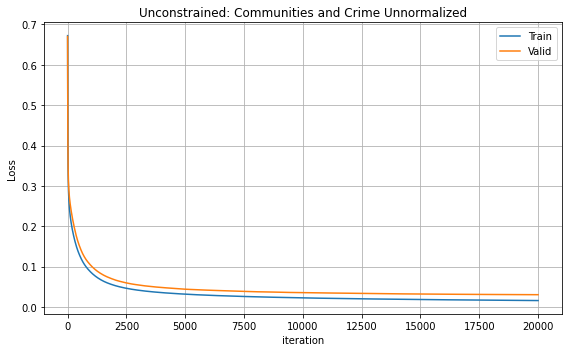

In [58]:
# Plot unconstrained loss function vs iterations
train_loss = pd.read_csv('data_lockdown_14BreastCancer/partitions/train_loss_fward05_1.csv')
valid_loss = pd.read_csv('data_lockdown_14BreastCancer/partitions/valid_loss_fward05_1.csv')

fig, axes = plt.subplots(figsize=(8,5))

axes.plot(train_loss["iteration"].tolist(), train_loss["loss"].tolist(), label="Train")
axes.plot(valid_loss["iteration"].tolist(), valid_loss["loss"].tolist(), label="Valid")
axes.legend()
axes.set_xlabel("iteration")
axes.set_ylabel("Loss")
axes.set_title("Unconstrained: Communities and Crime Unnormalized")
axes.grid(True, zorder=2)

plt.tight_layout()
# plt.savefig("data_unconstrained_friedman1_04/loss_vs_iter_forward.pdf", bbox_inches='tight')
plt.show()

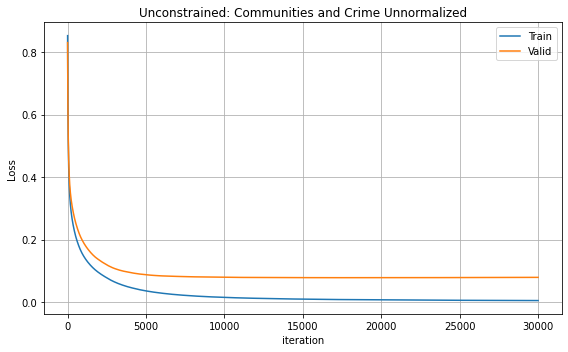

In [61]:
# Plot unconstrained loss function vs iterations
train_loss = pd.read_csv('data_lockdown_13LungCancer/partitions/train_loss_fward05_95.csv')
valid_loss = pd.read_csv('data_lockdown_13LungCancer/partitions/valid_loss_fward05_95.csv')

fig, axes = plt.subplots(figsize=(8,5))

axes.plot(train_loss["iteration"].tolist(), train_loss["loss"].tolist(), label="Train")
axes.plot(valid_loss["iteration"].tolist(), valid_loss["loss"].tolist(), label="Valid")
axes.legend()
axes.set_xlabel("iteration")
axes.set_ylabel("Loss")
axes.set_title("Unconstrained: Communities and Crime Unnormalized")
axes.grid(True, zorder=2)

plt.tight_layout()
# plt.savefig("data_unconstrained_friedman1_04/loss_vs_iter_forward.pdf", bbox_inches='tight')
plt.show()

* ### Comparison

In [4]:
# Read distributions
accuracy_lockdown = pd.read_csv('data_lockdown_11Radiotherapy/accuracy11_backward05.csv', index_col=0)
accuracy_forward  = pd.read_csv('data_unconstrained_11Radiotherapy/accuracy11_forward05.csv', index_col=0)
accuracy_xgb      = pd.read_csv('data_xgb_11Radiotherapy/accuracy11_xgb.csv')
accuracy_lasso    = pd.read_csv('data_lasso_11Radiotherapy/accuracy11_lasso_val.csv', index_col=0)

In [292]:
# Accuracy & Loss
print("Accuracy on 'test' set:")
print("Lockdown = {:.4f} +/- {:.3f}".format(accuracy_lockdown['test_acc'].mean(), 
                                            accuracy_lockdown['test_acc'].std()))
print("Forward  = {:.4f} +/- {:.3f}".format(accuracy_forward['test_acc'].mean(), 
                                            accuracy_forward['test_acc'].std()))
print("xgboost  = {:.4f} +/- {:.3f}".format(accuracy_xgb['test_acc'].mean(), 
                                            accuracy_xgb['test_acc'].std()))
print("Lasso    = {:.4f} +/- {:.3f}".format(accuracy_lasso['test_acc'].mean(), 
                                            accuracy_lasso['test_acc'].std()))

print("\nAccuracy on 'validation' set:")
print("Lockdown = {:.4f} +/- {:.3f}".format(accuracy_lockdown['valid_acc'].mean(), 
                                            accuracy_lockdown['valid_acc'].std()))
print("Forward  = {:.4f} +/- {:.3f}".format(accuracy_forward['valid_acc'].mean(), 
                                            accuracy_forward['valid_acc'].std()))
print("xgboost  = {:.4f} +/- {:.3f}".format(accuracy_xgb['valid_acc'].mean(), 
                                            accuracy_xgb['valid_acc'].std()))
print("Lasso    = {:.4f} +/- {:.3f}".format(accuracy_lasso['valid_acc'].mean(), 
                                            accuracy_lasso['valid_acc'].std()))

Accuracy on 'test' set:
Lockdown = 0.9328 +/- 0.060
Forward  = 0.8225 +/- 0.099
xgboost  = 0.8872 +/- 0.061
Lasso    = 0.9319 +/- 0.070

Accuracy on 'validation' set:
Lockdown = 0.9881 +/- 0.028
Forward  = 0.8423 +/- 0.094
xgboost  = 0.8884 +/- 0.067
Lasso    = 0.9384 +/- 0.052


In [293]:
# Print out test results
print("On 'test' set:")
statistic, pvalue = stats.ttest_rel(accuracy_lockdown['test_acc'], accuracy_forward['test_acc'])
print("Lockdown vs Forward: pvalue={:e}, statistic={:e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(accuracy_lockdown['test_acc'], accuracy_xgb['test_acc'])
print("Lockdown vs xgboost: pvalue={:e}, statistic={:e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(accuracy_lockdown['test_acc'], accuracy_lasso['test_acc'])
print("Lockdown vs lasso:   pvalue={:e}, statistic={:e}".format(pvalue, statistic))

# 
print("\nOn 'validation' set:")
statistic, pvalue = stats.ttest_rel(accuracy_lockdown['valid_acc'], accuracy_forward['valid_acc'])
print("Lockdown vs Forward: pvalue={:e}, statistic={:e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(accuracy_lockdown['valid_acc'], accuracy_xgb['valid_acc'])
print("Lockdown vs xgboost: pvalue={:e}, statistic={:e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(accuracy_lockdown['valid_acc'], accuracy_lasso['valid_acc'])
print("Lockdown vs lasso:   pvalue={:e}, statistic={:e}".format(pvalue, statistic))

On 'test' set:
Lockdown vs Forward: pvalue=3.273102e-20, statistic=1.162461e+01
Lockdown vs xgboost: pvalue=2.098814e-10, statistic=7.081283e+00
Lockdown vs lasso:   pvalue=8.790696e-01, statistic=1.525424e-01

On 'validation' set:
Lockdown vs Forward: pvalue=1.190889e-28, statistic=1.571537e+01
Lockdown vs xgboost: pvalue=1.636761e-28, statistic=1.564500e+01
Lockdown vs lasso:   pvalue=7.477341e-20, statistic=1.145793e+01


In [7]:
# Relative Root Mean Squared Error
rrmse_lasso = 1.0 - accuracy_lasso['test_acc']
print("Lasso   = {:.3f} +/- {:.3f}".format(rrmse_lasso.mean(), rrmse_lasso.std()))

rrmse_GB = 1.0 - accuracy_xgb['test_acc']
print("GB      = {:.3f} +/- {:.3f}".format(rrmse_GB.mean(), rrmse_GB.std()))

rrmse_fcnn = 1.0 - accuracy_forward['test_acc']
print("FCNN    = {:.3f} +/- {:.3f}".format(rrmse_fcnn.mean(), rrmse_fcnn.std()))

rrmse_lockout = 1.0 - accuracy_lockdown['test_acc']
print("Lockout = {:.3f} +/- {:.3f}".format(rrmse_lockout.mean(), rrmse_lockout.std()))

# Print out test results
print("\nOn 'test' set:")
statistic, pvalue = stats.ttest_rel(rrmse_lockout, rrmse_fcnn)
print("Lockdown vs Forward: pvalue={:.2e}, statistic={:.2e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(rrmse_lockout, rrmse_GB)
print("Lockdown vs xgboost: pvalue={:.2e}, statistic={:.2e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(rrmse_lockout, rrmse_lasso)
print("Lockdown vs lasso:   pvalue={:.2e}, statistic={:.2e}".format(pvalue, statistic))

Lasso   = 0.068 +/- 0.070
GB      = 0.113 +/- 0.061
FCNN    = 0.177 +/- 0.099
Lockout = 0.067 +/- 0.060

On 'test' set:
Lockdown vs Forward: pvalue=3.27e-20, statistic=-1.16e+01
Lockdown vs xgboost: pvalue=2.10e-10, statistic=-7.08e+00
Lockdown vs lasso:   pvalue=8.79e-01, statistic=-1.53e-01
